# <center>Individual Data Mining Assignment</center>
<center>By: Mikolaj Hilgert</center>

# Introduction
Arthritis, a group of conditions characterized by inflammation and pain in the joints, affects millions of individuals worldwide and presents diverse subtypes, each requiring tailored treatment strategies. Accurate identification of the type of arthritis is critical for effective management and improving patient outcomes. This project explores the potential of machine learning techniques to classify arthritis types in adults using data from the National Health and Nutrition Examination Survey (NHANES), a comprehensive dataset that captures socio-demographic, clinical, and diagnostic information.

The primary objective of this project is to develop a machine learning pipeline capable of accurately predicting arthritis types. Through a data-mining approach, the project aims to not only advances the understanding of arthritis subtype classification but also demonstrates the practical applications of machine learning in the field of healthcare.

### Contextualising the problem

**Data mining** is a field that focuses on extracting insights and patterns from large datasets. That as of itself already constitutes a strong argument in favour of using such a process when tackling business problems, but there is still more to it.



As such, this project proposes to answer the following problem statement and research questions:


#### Problem Statement:
**To what extent can machine learning techniques accurately predict the type of arthritis in adults within the NHANES population?**

#### Sub Questions:
The problem statement is supported by these sub-questions.
- What are the significant associations between participant characteristics and arthritis types in the NHANES dataset?
- Which features are most influential in predicting arthritis types, and how does feature selection impact model performance?
- Among various classification models and evaluation metrics, which combination yields the best performance in predicting arthritis types?


### Data Mining Methodology 

The Cross-Industry Standard Process for Data Mining (CRISP-DM) Methodology was used to build the deliverable of the assignment (it is pictured below). It organizes the data mining project in six phases (Business Understanding, Data Understanding, Data preparation, Modeling, Evaluation and Deployment).

<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" alt="CRISP-DM Process" style="width:400px;height:400px;margin-top: 20px;">
</div>

Figure 1: CRISP-DM Process Diagram 

1. *Business Understanding*: TThe goal of this project is to predict the type of arthritis a patient has based on their clinical and diagnostic data, enabling healthcare professionals to make quicker and more precise diagnoses. The project's success will be measured by its F1 score, which balances precision and recall to evaluate the model's effectiveness in correctly classifying arthritis types. This metric is crucial to ensuring both accurate identification and minimizing misclassification, thereby supporting timely and effective treatment. A higher F1 score reflects a robust model that healthcare professionals can trust for reliable and actionable insights, ultimately improving patient outcomes.

2. *Data Understanding*: This step involves exploring the NHANES dataset which contains data on patient demographics, lab results, diet, examination results, used medications and patient questionnaires. Initial exploration will focus on understanding the data distribution, identifying patterns, and assessing data quality (e.g., detecting outliers and missing values).

3. *Data Preparation*: In this phase, the dataset will be prepared for modeling by addressing missing values, outliers, and issues such as multicollinearity. Feature engineering techniques like scaling, standardization, and normalization will be applied to ensure uniformity in data. Transformations, such as encoding categorical variables and applying clustering and association rules mining to enhance the dataset's predictive power and the performance of the models.

4. *Modelling*: Since this is a multi-class classification problem, several predictive models will be employed, including SVM, XGBOOST, artificial neural networks, and logistic regression. The dataset will be split into training and testing sets, with models trained on the training set. Hyperparameter tuning using grid search will be conducted to optimize model performance. The focus will be on identifying the best-performing model based on accuracy and other complementary metrics.

5. *Evaluation*: The primary evaluation metric for this project is accuracy, as it directly reflects the model's ability to correctly classify the type of arthritis. This focus is motivated by the critical need for precise diagnoses in medical contexts. Additionally, supporting metrics such as precision, recall, and ROC-AUC are considered. By comparing models on these metrics, the most reliable and clinically applicable model will be selected to meet both the data science and healthcare objectives.

6. *Deployment*: This step is omitted.

# Data Understanding

### Installing and importing relevant modules

In [23]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: C:\Users\mikol\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import pickle

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from mlxtend.frequent_patterns import fpgrowth, association_rules

import warnings

# Set up the environment
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Constants
DATA_FOLDER = 'data'
RANDOM_STATE = 0

### Loading the raw data

In [25]:
# Load the questionnaire dataset
questionnaire_df = pd.read_csv("./data/questionnaire.csv", encoding='ISO-8859-1')

# MCQ160A: Ever told you had arthritis (target)
merged_df = questionnaire_df[questionnaire_df['MCQ160A'].notnull()]

# Merge with other datasets
for csv_file in ['demographic.csv', 'labs.csv', 'diet.csv', 'examination.csv']:
    temp_df = pd.read_csv(f"./data/{csv_file}", encoding='ISO-8859-1')
    merged_df = pd.merge(merged_df, temp_df, on='SEQN', how='inner', suffixes=('', ''))

# Drop duplicate rows
merged_df = merged_df.drop_duplicates()
merged_df.head(5)

SEQN  ACD011A  ACD011B  ACD011C  ACD040  ACD110  ALQ101  ALQ110  ALQ120Q  \
0  73557      1.0      NaN      NaN     NaN     NaN     1.0     NaN      1.0   
1  73558      1.0      NaN      NaN     NaN     NaN     1.0     NaN      7.0   
2  73559      1.0      NaN      NaN     NaN     NaN     1.0     NaN      0.0   
3  73561      1.0      NaN      NaN     NaN     NaN     1.0     NaN      0.0   
4  73562      NaN      NaN      NaN     4.0     NaN     1.0     NaN      5.0   

   ALQ120U  ALQ130  ALQ141Q  ALQ141U  ALQ151  ALQ160  BPQ020  BPQ030  BPD035  \
0      3.0     1.0      0.0      NaN     1.0     NaN     1.0     1.0    62.0   
1      1.0     4.0      2.0      1.0     1.0     0.0     1.0     1.0    53.0   
2      NaN     NaN      NaN      NaN     2.0     NaN     1.0     1.0    40.0   
3      NaN     NaN      NaN      NaN     2.0     NaN     1.0     2.0    55.0   
4      3.0     1.0      0.0      NaN     2.0     0.0     1.0     1.0    35.0   

   BPQ040A  BPQ050A  BPQ056  BPD058  BPQ059  BPQ080  BPQ060  BPQ070  BPQ090D  \
0      1.0      2.0     2.0     NaN     2.0     1.0     NaN     1.0      1.0   
1      2.0      NaN     1.0    52.0     2.0     1.0     NaN     1.0      1.0   
2      1.0      1.0     2.0     NaN     2.0     1.0     NaN     1.0      1.0   
3      1.0      1.0     1.0    12.0     2.0     2.0     1.0     1.0      2.0   
4      1.0      1.0     1.0   365.0     1.0     1.0     NaN     2.0      1.0   

   BPQ100D  CBD070  CBD090  CBD110  CBD120  CBD130  HSD010  HSQ500  HSQ510  \
0      1.0   300.0     0.0    50.0     0.0    85.0     2.0     2.0     2.0   
1      1.0   642.0   214.0   128.0    40.0    20.0     4.0     2.0     2.0   
2      1.0   150.0    25.0     0.0    40.0     0.0     3.0     2.0     2.0   
3      NaN   200.0     0.0    40.0     0.0     0.0     5.0     2.0     2.0   
4      1.0   150.0    60.0     0.0    60.0     0.0     5.0     2.0     2.0   

   HSQ520  HSQ571  HSQ580  HSQ590  HSAQUEX  CSQ010  CSQ020  CSQ030  CSQ040  \
0     2.0     2.0     NaN     2.0      2.0     2.0     3.0     2.0     2.0   
1     2.0     2.0     NaN     2.0      2.0     2.0     3.0     2.0     2.0   
2     2.0     2.0     NaN     2.0      2.0     2.0     3.0     2.0     2.0   
3     2.0     2.0     NaN     2.0      2.0     2.0     3.0     1.0     2.0   
4     2.0     2.0     NaN     2.0      2.0     1.0     2.0     1.0     1.0   

   CSQ060  CSQ070  CSQ080  CSQ090A  CSQ090B  CSQ090C  CSQ090D  CSQ100  CSQ110  \
0     NaN     NaN     2.0      3.0      3.0      3.0      3.0     1.0     2.0   
1     NaN     NaN     2.0      3.0      3.0      3.0      3.0     1.0     2.0   
2     NaN     NaN     2.0      3.0      3.0      3.0      3.0     1.0     2.0   
3     NaN     NaN     2.0      3.0      3.0      3.0      3.0     1.0     2.0   
4     4.0     2.0     1.0      2.0      2.0      2.0      2.0     2.0     1.0   

   CSQ120A  CSQ120B  CSQ120C  CSQ120D  CSQ120E  CSQ120F  CSQ120G  CSQ120H  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN      NaN      NaN      NaN      5.0      NaN      NaN      NaN   

   CSQ140  CSQ160  CSQ170  CSQ180  CSQ190  CSQ200  CSQ202  CSQ204  CSQ210  \
0     NaN     NaN     NaN     NaN     NaN     2.0     1.0     2.0     2.0   
1     NaN     NaN     NaN     NaN     NaN     2.0     2.0     2.0     1.0   
2     NaN     NaN     NaN     NaN     NaN     2.0     2.0     2.0     1.0   
3     NaN     2.0     NaN     2.0     2.0     2.0     2.0     2.0     1.0   
4     3.0     2.0     NaN     2.0     1.0     2.0     1.0     2.0     1.0   

   CSQ220  CSQ240  CSQ250  CSQ260  AUQ136  AUQ138  CDQ001  CDQ002  CDQ003  \
0     2.0     2.0     2.0     2.0     2.0     2.0     2.0     NaN     NaN   
1     2.0     2.0     2.0     2.0     2.0     2.0     1.

In [26]:
merged_df.shape[0]

5588

In the code above, I merge the questionnaire file with the other datasets with the exception with medication.

### Combining of the data with description file found in Kaggle(put link here) discussion

In [27]:
# Load the variable descriptions
variable_descriptions = pd.read_excel('./variable_description.xlsx')
variable_descriptions['Variable Name'] = variable_descriptions['Variable Name'].str.upper()

# Filter descriptions for columns present in the dataframe
descriptions = variable_descriptions[variable_descriptions['Variable Name'].isin(merged_df.columns)]

# Identify columns without descriptions
no_explanation = set(merged_df.columns) - set(descriptions['Variable Name'])

# Make a dict of the descriptions
descriptions = descriptions.set_index('Variable Name')['Variable Description'].to_dict()

print(descriptions)

{'SEQN': 'Respondent sequence number', 'RIDSTATR': 'Interview and examination status of the participant.', 'RIAGENDR': 'Gender of the participant.', 'RIDAGEYR': 'Age in years of the participant at the time of screening. Individuals 80 and over are topcoded at 80 years of age.', 'RIDAGEMN': 'Age in months of the participant at the time of screening. Individuals aged 959 months and older are topcoded at 959 months.', 'RIDRETH1': 'Recode of reported race and Hispanic origin information', 'DMDCITZN': '{Are you/Is SP} a citizen of the United States? [Information about citizenship is being collected by the U.S. Public Health Service to perform health related research. Providing this information is voluntary and is collected under the authority of the Public Health Service Act. There will be no effect on pending immigration or citizenship petitions.]', 'DMDYRSUS': 'Length of time the participant has been in the US.', 'DMDEDUC3': 'What is the highest grade or level of school {you have/SP has} 

Given this dictionary, it is possible to review all the columns along with their descriptions.

In [28]:
for col in merged_df.columns:
    print(f"{col}: {descriptions.get(col, 'No description')}")

SEQN: Respondent sequence number
ACD011A: What language(s) {do you/does SP} usually speak at home?
ACD011B: What language(s) {do you/does SP} usually speak at home?
ACD011C: What language(s) {do you/does SP} usually speak at home?
ACD040: Now I'm going to ask you about language use. What language(s) {do you/does SP} usually speak at home? {Do you/Does he/Does she} speak only Spanish, more Spanish than English, both equally, more English than Spanish, or only English?
ACD110: {Do you/Does SP} speak only (NON-ENGLISH LANGUAGE), more (NON-ENGLISH LANGUAGE) than English, both equally, more English than (NON-ENGLISH LANGUAGE), or only English?
ALQ101: The next questions are about drinking alcoholic beverages. Included are liquor (such as whiskey or gin), beer, wine, wine coolers, and any other type of alcoholic beverage.In any one year, {have you/has SP} had at least 12 drinks of any type of alcoholic beverage? By a drink, I mean a 12 oz. beer, a 5 oz. glass of wine, or one and half ounces 

In [29]:
print("Columns without descriptions:")
print(no_explanation)

Columns without descriptions:
{'LBDRPCR.x', 'LBDR64.x', 'LBDR66.y', 'WTSA2YR.y', 'LBDR51.y', 'LBDR72.y', 'SMAQUEX.y', 'LBDR54.x', 'LBDR31.y', 'LBDR73.y', 'LBDR73.x', 'LBDR11.x', 'LBDR11.y', 'PHAFSTMN.x', 'LBDR51.x', 'LBDR81.x', 'LBDR83.y', 'URXUCR.x', 'WTSH2YR.y', 'LBDR61.y', 'LBDR16.x', 'LBDR62.y', 'PHAFSTHR.x', 'LBDR39.y', 'LBDRHP.x', 'LBDR40.x', 'LBDR55.y', 'LBDR89.x', 'LBDR58.x', 'LBDR68.x', 'PHAFSTHR.y', 'URXUCR.y', 'LBDR54.y', 'LBDR45.y', 'LBDR61.x', 'LBDR89.y', 'LBDR45.x', 'DR1.300', 'LBDR53.y', 'LBDR33.y', 'LBDR52.x', 'LBDR72.x', 'LBDRPI.x', 'LBDR84.y', 'WTSB2YR.y', 'LBDR69.x', 'LBDR62.x', 'DR1.330Z', 'LBDR66.x', 'WTSAF2YR.y', 'LBDR39.x', 'LBDRLP.y', 'LBDR42.y', 'DR1.320Z', 'LBDR35.y', 'LBDR26.y', 'LBDR58.y', 'LBDR53.x', 'LBXAPB', 'LBDR67.y', 'LBDR56.x', 'LBDR83.x', 'LBDR42.x', 'LBDR40.y', 'LBDRHP.y', 'LBDR59.x', 'LBDRPCR.y', 'LBDR81.y', 'LBDR59.y', 'WTSB2YR.x', 'LBDR35.x', 'LBDR70.x', 'LBDR64.y', 'LBDR06.y', 'LBDR52.y', 'LBDR68.y', 'LBDR82.x', 'LBDR26.x', 'LBDRLP.x', 'LBDR84.x

In the output above, one can see that there are some columns that do not have a valid description, when looking at these results - they are existing features with a '.x' or '.y', this often happens due to data merging. As such, it was decided to drop them as without a description they hold no value.

In [30]:
# Drop the columns without descriptions
merged_df = merged_df.drop(columns=no_explanation)

### Initial feature selection

In the code blocks below, I apply the Random Forest classifier as an initial feature selection. Next step is to take the top-10 most important features for out target variable, this can aid in adding some features that would not be identified by just assessing the target domain.

In [31]:
feature_df = merged_df.copy()
# Encode categorical columns
label_encoders = {col: LabelEncoder() for col in feature_df.select_dtypes(include='object').columns}
for col, le in label_encoders.items():
    feature_df[col] = le.fit_transform(feature_df[col].astype(str))

# Drop rows with MCQ195 missing values
feature_df = feature_df.dropna(subset=['MCQ195'])

# Prepare features and target
X = feature_df.drop(columns=['MCQ195'])
y = LabelEncoder().fit_transform(feature_df['MCQ195']) # if feature_df['MCQ195'].dtype == 'object' else feature_df['MCQ195']

# Split data and train the Random Forest model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE).fit(X_train, y_train)

# Feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)

print("Feature Importances (top-10):")
for _, row in feature_importances.head(10).iterrows():
    print(f"Feature: {row['Feature']}, Description: {descriptions.get(row['Feature'], 'No description')}, Importance: {row['Importance']:.3f}")

Feature Importances (top-10):
Feature: WTMEC2YR, Description: Full sample 2 year MEC exam weight., Importance: 0.009
Feature: WTINT2YR, Description: Full sample 2 year interview weight., Importance: 0.008
Feature: WTDRD1, Description: Dietary day one sample weight, Importance: 0.007
Feature: INDFMPIR, Description: A ratio of family income to poverty guidelines., Importance: 0.005
Feature: INDFMMPI, Description: Family monthly poverty level index, a ratio of monthly family income to the HHS poverty guidelines specific to family size., Importance: 0.005
Feature: URXUMA, Description: Albumin, urine (ug/mL), Importance: 0.004
Feature: LBXSAPSI, Description: Alkaline phosphatase (IU/L), Importance: 0.004
Feature: URDACT, Description: Albumin creatinine ratio (mg/g), Importance: 0.003
Feature: URXCRS, Description: Creatinine, urine (umol/L), Importance: 0.003
Feature: URXUMS, Description: Albumin, urine (mg/L), Importance: 0.003


Then, as part of the literature review, a few relevant indicators for arthritis were identified, as based on the following CDC website: https://www.cdc.gov/arthritis/risk-factors/index.html

In [32]:
mapping = {
    # Target Variable
    "MCQ195": "type_of_arthritis",  # Identifies specific arthritis type for targeted analysis.

    # Demographics
    "RIAGENDR": "gender", # Person's gender
    "RIDAGEYR": "age", # Person's age in years
    "INDHHIN2": "annual_household_income",  # Household income can impact arthritis risk and management.    
    "DMDHREDU": "education_level",  
    
    # General Health
    "HSD010": "general_health_status",  # Overall health perception, which can influence arthritis outcomes.
    "OSQ080": "broke_bone_after_20",  # Bone fractures can impact arthritis risk and severity.
    "LBXSGL": "glucose_mg_dl",  # Fasting glucose levels can impact arthritis risk and management.

    # Weight and Obesity
    "MCQ080": "ever_diagnosed_as_overweight",  # Clinical diagnosis of overweight status, a known risk factor for arthritis.

    # Physical Activity and Mobility
    "DLQ050": "difficulty_walking_or_climbing_stairs",  # Assesses mobility limitations often associated with arthritis.
    "DLQ060": "difficulty_dressing_or_bathing",  # Evaluates daily living challenges faced by arthritis patients.
    "DMQMILIZ": "served_in_military",  # Military service can impact arthritis risk due to physical demands and injuries.

    # Smoking
    "SMQ020": "smoked_100_cigarettes_lifetime",  # Smoking is a modifiable risk factor linked to arthritis development and progression.

    # Medical Conditions
    "BPQ020": "ever_diagnosed_with_hypertension",  # Hypertension is associated with systemic inflammation, impacting arthritis.
    "BPQ080": "ever_diagnosed_with_high_cholesterol",  # Dyslipidemia can contribute to systemic inflammation.
    "DIQ010": "ever_diagnosed_with_diabetes",  # Diabetes is linked to inflammation and joint health.
    "MCQ070": "ever_diagnosed_with_psoriasis",  # Psoriasis is related to psoriatic arthritis.
    "MCQ082": "ever_diagnosed_with_celiac_disease",  # Celiac disease can have joint-related manifestations.

    # Healthcare Utilization and Access
    "HUQ051": "doctor_visits_last_12_months",  # Frequency of healthcare visits may reflect disease severity or management.
    "HUQ071": "hospitalization_overnight_last_12_months",  # Indicates severe health episodes possibly related to arthritis complications.

    # Added as of RF feature importance analysis, some have been removed due to being essentially being duplicate information
    "WTMEC2YR": "mec_exam_weight_2yr",
    "INDFMPIR": "income_to_poverty_ratio",
    "WTDRD1": "dietary_day_one_sample_weight",
    "LBXSAPSI": "alkaline_phosphatase_iu_per_l",
    "URDACT": "albumin_creatinine_ratio_mg_per_g",
    "URXCRS": "creatinine_urine_umol_per_l",
}

Given the above mappings, one can drop the other columns in our dataset. Given the shear amount of available columns- keeping them would increase the complexity of the model and reduce training time.

In [33]:
# Filter merged_df to only include columns in mapping, then rename them using the mapping dictionary
df = merged_df[list(mapping.keys())].rename(columns=mapping)

As such, the dataframe information below is listed:

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5588 entries, 0 to 5587
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   type_of_arthritis                         1467 non-null   float64
 1   gender                                    5588 non-null   int64  
 2   age                                       5588 non-null   int64  
 3   annual_household_income                   5513 non-null   float64
 4   education_level                           5426 non-null   float64
 5   general_health_status                     5124 non-null   float64
 6   broke_bone_after_20                       3708 non-null   float64
 7   glucose_mg_dl                             5328 non-null   float64
 8   ever_diagnosed_as_overweight              5588 non-null   float64
 9   difficulty_walking_or_climbing_stairs     5588 non-null   float64
 10  difficulty_dressing_or_bathing      

Next, it is possible to take a look at whether there is missing data in this reduced dataset.

In [35]:
print("Missing data in the dataframe:")
print(df.isnull().sum())

Missing data in the dataframe:
type_of_arthritis                           4121
gender                                         0
age                                            0
annual_household_income                       75
education_level                              162
general_health_status                        464
broke_bone_after_20                         1880
glucose_mg_dl                                260
ever_diagnosed_as_overweight                   0
difficulty_walking_or_climbing_stairs          0
difficulty_dressing_or_bathing                 0
served_in_military                             0
smoked_100_cigarettes_lifetime                 0
ever_diagnosed_with_hypertension               0
ever_diagnosed_with_high_cholesterol           0
ever_diagnosed_with_diabetes                   0
ever_diagnosed_with_psoriasis                  0
ever_diagnosed_with_celiac_disease             0
doctor_visits_last_12_months                   0
hospitalization_overnight_last_12_mont

As seen above, there are quite a few missing values; therefore, either deal with columns where some method can be inferred to handle them or drop rows with `na` values entirely.

In [36]:
# If they didnt break a bone after 20, we can fill the type of arthritis with 0
df['broke_bone_after_20'].fillna(0, inplace=True)
df['type_of_arthritis'].fillna(0, inplace=True)

In [37]:
# Drop NAs
print("Number of columns before removing NAs:", len(df))
df = df.dropna()
print("Number of columns after removing NAs:", len(df))

Number of columns before removing NAs: 5588
Number of columns after removing NAs: 4380


### Plotting of numericals

Given that categorical variables are represented in number form, it is necessary to manually assess which columns are numerical. This is done below.

In [38]:
continuous_columns = ["mec_exam_weight_2yr", "income_to_poverty_ratio", "dietary_day_one_sample_weight",
                     "alkaline_phosphatase_iu_per_l", "albumin_creatinine_ratio_mg_per_g",
                     "creatinine_urine_umol_per_l", "age", "glucose_mg_dl"]

# Categorical columns
categorical_columns = df.columns.difference(continuous_columns).tolist()

The descriptive statistics of the dataframe are shown below:

In [39]:
df[continuous_columns].describe()

mec_exam_weight_2yr  income_to_poverty_ratio  \
count          4380.000000              4380.000000   
mean          42551.983423                 2.537018   
std           31642.943175                 1.647495   
min            5751.715759                 0.000000   
25%           20095.133036                 1.070000   
50%           29365.478281                 2.150000   
75%           58560.552295                 4.160000   
max          171075.161241                 5.000000   

       dietary_day_one_sample_weight  alkaline_phosphatase_iu_per_l  \
count                    4380.000000                    4380.000000   
mean                    44212.779235                      66.329224   
std                     40990.898930                      22.264942   
min                         0.000000                       9.000000   
25%                     16638.904091                      52.000000   
50%                     30210.315474                      63.000000   
75%                     58124.288842                      76.000000   
max                    267526.890966                     334.000000   

       albumin_creatinine_ratio_mg_per_g  creatinine_urine_umol_per_l  \
count                        4380.000000                  4380.000000   
mean                           46.688078                 10566.343014   
std                           324.557012                  6952.415984   
min                             0.260000                   442.000000   
25%                             4.820000                  5215.600000   
50%                             7.320000                  9193.600000   
75%                            14.060000                 14232.400000   
max                          9000.000000                 46321.600000   

               age  glucose_mg_dl  
count  4380.000000    4380.000000  
mean     49.417352     104.822603  
std      17.501685      40.958049  
min      20.000000      49.000000  
25%      34.000000      87.000000  
50%      49.000000      95.000000  
75%      64.000000     107.000000  
max      80.000000     577.000000

It is also possible to take a look at the Pairplot of the numerical columns for more visual insight:

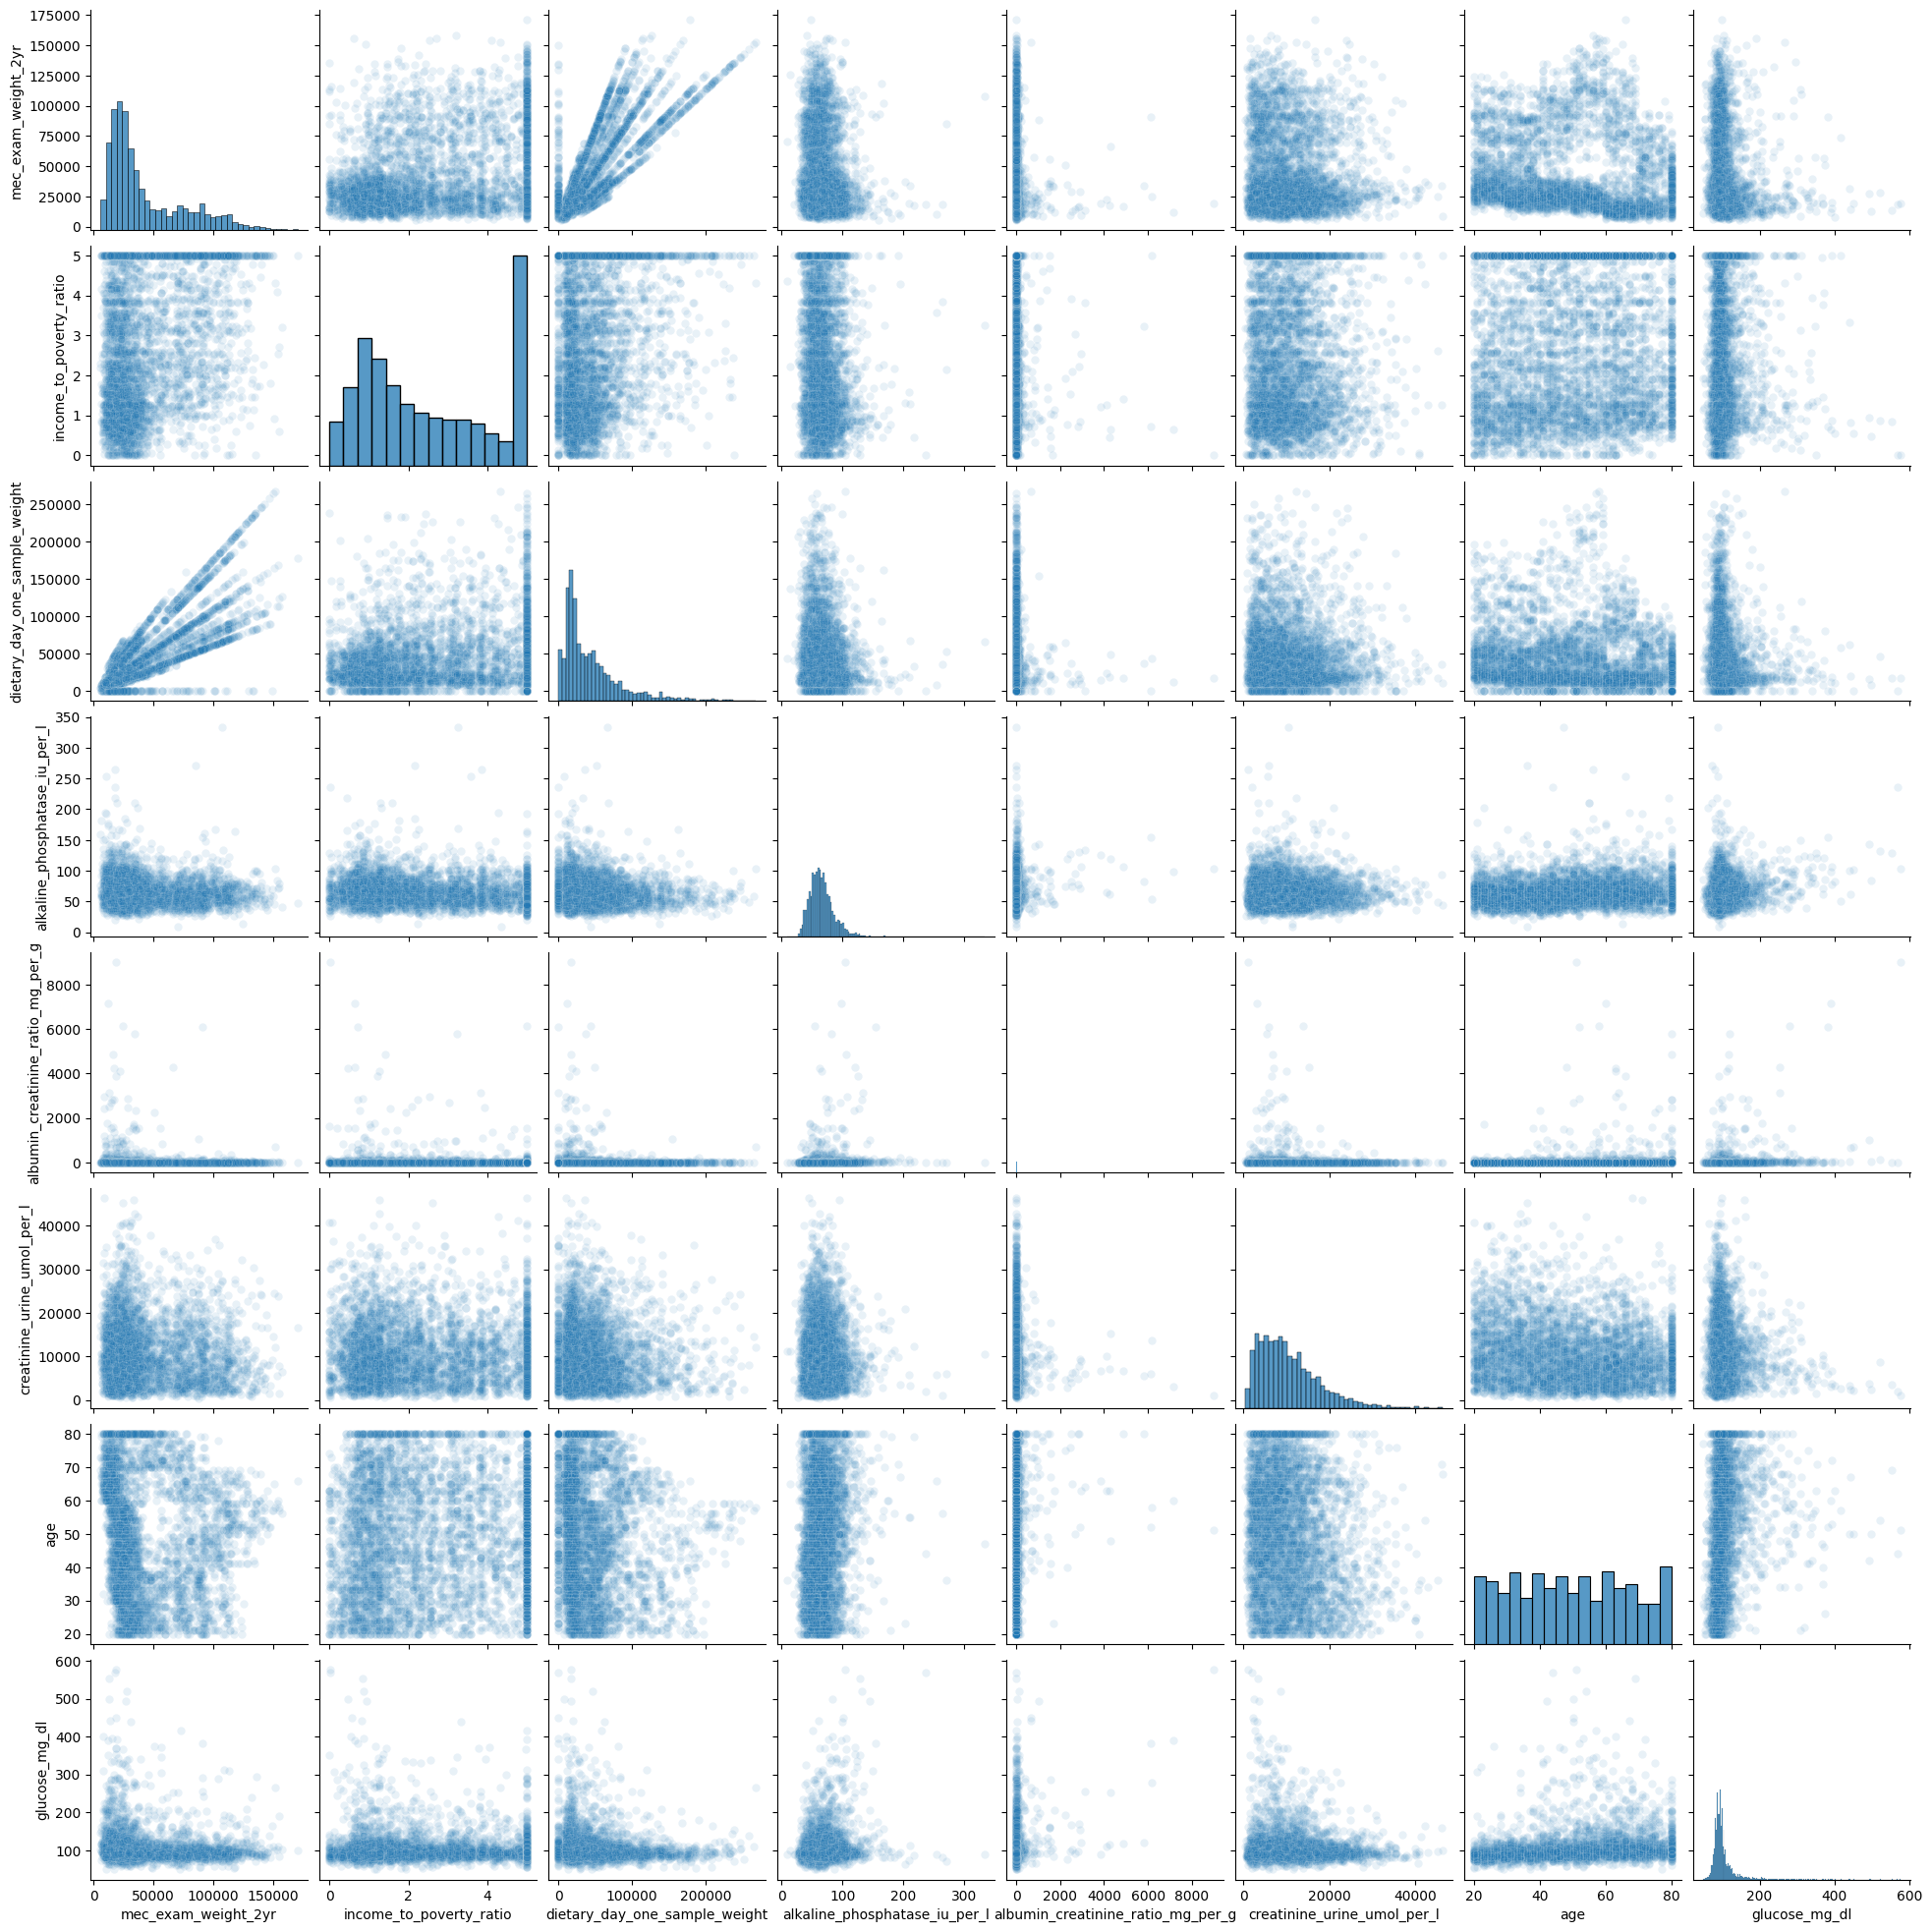

In [40]:
# Numerical Pairplot according to response variable
sns.pairplot(df[continuous_columns], plot_kws={'alpha':0.1})
plt.show()

From the plots above, it is evident that there are numerous numerical features that are right skewed. This will be addressed at a later stage using log scaling.

Next, it is possible to take a look at the outliers in the dataset.

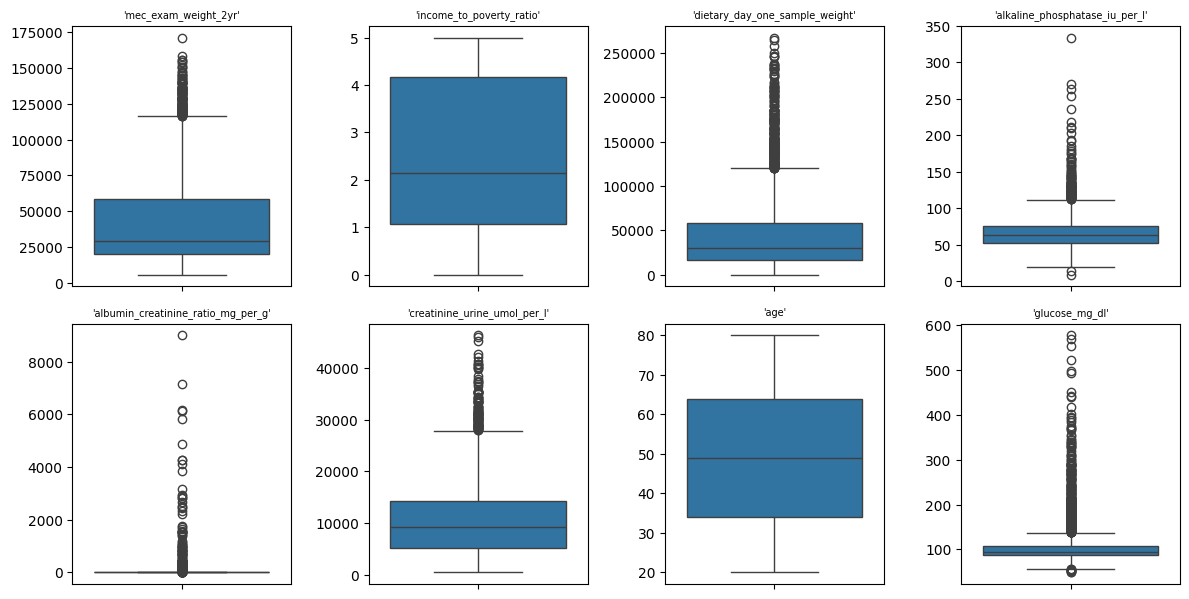

In [41]:
def create_boxplots(df, columns, rows=4, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()  

    for i, column in enumerate(columns):
        sns.boxplot(data=df, y=column, ax=axes[i])
        axes[i].set_title(f"'{column}'", fontsize=7)
        axes[i].set_ylabel('')

    # Remove any empty subplots if there are fewer columns than grid spaces
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

create_boxplots(df, continuous_columns)

Given these results, while it is possible to consider removing outliers, given the prediction goals, all of these can be indicators and therefore can be treated as relevant data. Therefore, nothing is removed.

### Target Variable Exploration

As explained at the beginning of this notebook, the type of arthritis is selected as the target variable. This variable is present in the original dataset as `MCQ195`, and is found within the `questionnaire.csv` file. 

Looking at the National Health and Nutrition Examination Survey Data Documentation [website](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/MCQ_J.htm), a deeper understanding of what the categories in the dataset represent can be gained:

**English Text:** Which type of arthritis was it?  
**Target:** Both males and females 20 YEARS - 150 YEARS  

| Code or Value | Value Description                       | 
|---------------|-----------------------------------------|
| 1             | Osteoarthritis or degenerative arthritis|
| 2             | Rheumatoid arthritis                    | 
| 3             | Psoriatic arthritis                     | 
| 4             | Other                                   | 
| 7             | Refused                                 | 
| 9             | Don’t know                              | 
| 0             | Missing                                 | 


Exploring the values of arthritis classes within the report reveals that many individuals are unaware of their specific type of arthritis. Developing an accurate model could enable predictions for these individuals, as shown in the plot below.

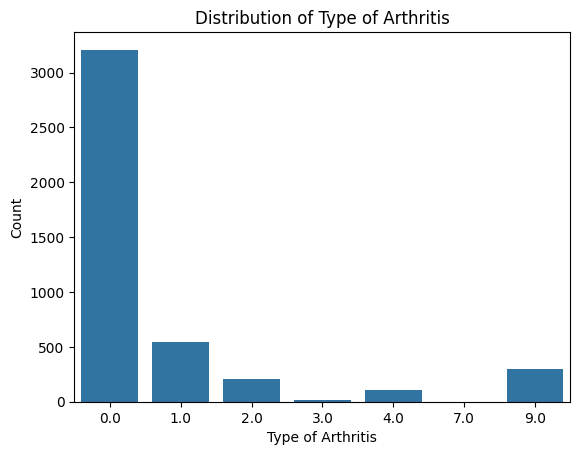

In [42]:
sns.countplot(data=df, x='type_of_arthritis')
plt.title('Distribution of Type of Arthritis')
plt.xlabel('Type of Arthritis')
plt.ylabel('Count')
plt.show()

For the time being, we drop the rows in which we do not know the outcome.

In [43]:
df_dont_know = df[df['type_of_arthritis'] == 9]
df = df[~df['type_of_arthritis'].isin([4, 7, 9])]
df = df.reset_index(drop=True)
df

type_of_arthritis  gender  age  annual_household_income  \
0                   0.0       1   54                      7.0   
1                   0.0       1   72                     10.0   
2                   2.0       1   56                      9.0   
3                   2.0       2   61                     10.0   
4                   2.0       2   56                      4.0   
...                 ...     ...  ...                      ...   
3966                0.0       1   58                      3.0   
3967                0.0       1   36                      8.0   
3968                0.0       1   52                     15.0   
3969                0.0       1   61                     10.0   
3970                1.0       1   80                      8.0   

      education_level  general_health_status  broke_bone_after_20  \
0                 3.0                    4.0                  2.0   
1                 4.0                    3.0                  2.0   
2                 4.0                    5.0                  2.0   
3                 5.0                    3.0                  2.0   
4                 3.0                    3.0                  1.0   
...               ...                    ...                  ...   
3966              1.0                    2.0                  2.0   
3967              4.0                    1.0                  0.0   
3968              5.0                    2.0                  2.0   
3969              2.0                    4.0                  2.0   
3970              3.0                    2.0                  2.0   

      glucose_mg_dl  ever_diagnosed_as_overweight  \
0             219.0                           2.0   
1             183.0                           2.0   
2             104.0                           1.0   
3             107.0                           1.0   
4             108.0                           2.0   
...             ...                           ...   
3966          129.0                           2.0   
3967           92.0                           2.0   
3968           87.0                           2.0   
3969          155.0                           2.0   
3970          117.0                           2.0   

      difficulty_walking_or_climbing_stairs  difficulty_dressing_or_bathing  \
0                                       2.0                             2.0   
1                                       2.0                             2.0   
2                                       1.0                             2.0   
3                                       2.0                             2.0   
4                                       2.0                             2.0   
...                                     ...                             ...   
3966                                    2.0                             2.0   
3967                                    2.0                             2.0   
3968                                    2.0                             2.0   
3969                                    2.0                             2.0   
3970                                    2.0                             2.0   

      served_in_military  smoked_100_cigarettes_lifetime  \
0                    2.0                             1.0   
1                    1.0                             1.0   
2                    1.0                             1.0   
3                    2.0                             2.0   
4                    2.0                             1.0   
...                  ...                             ...   
3966                 2.0                             1.0   
3967                 2.0                             2.0   
3968                 2.0                             2.0   
3969                 2.0                             2.0   
3970                 2.0                             1.0   

      ever_diagnosed_with_hypertension  ever_diagnosed_with_high_cholesterol  \
0        

Next, the distributions of each categorical variable can be examined in relation to the target variable to identify any interesting insights.

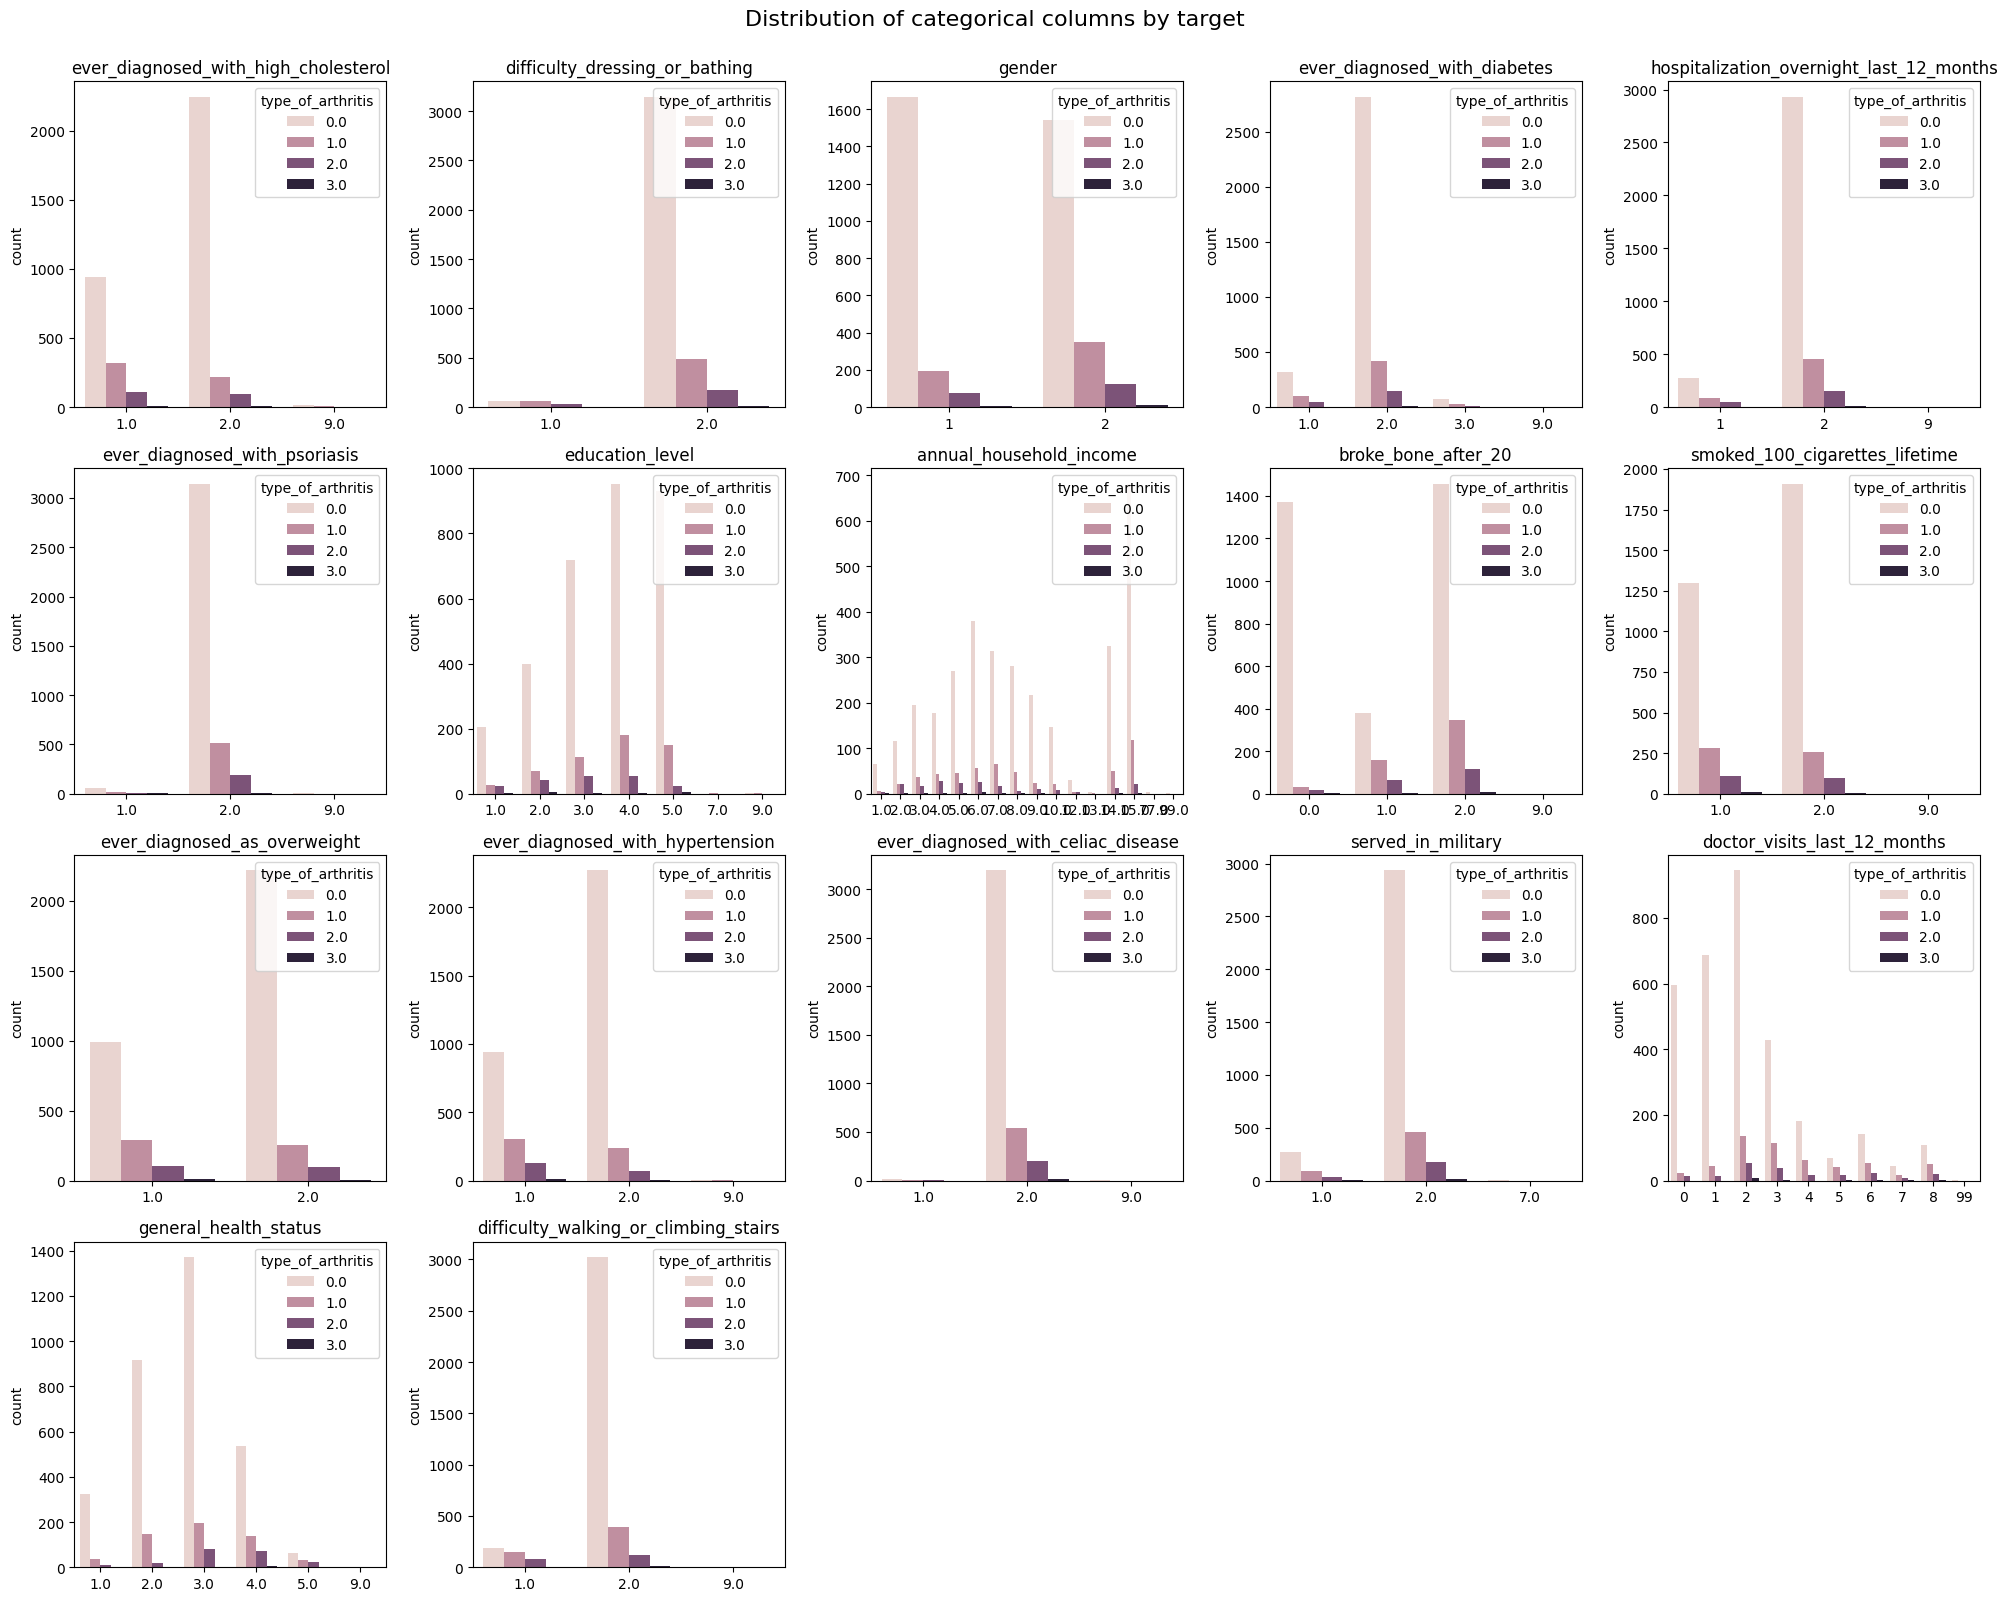

In [44]:
def plot_categorical_distributions(df, target_col, cols, rows=5, cols_per_row=5):
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(20, 20))
    axes = axes.flatten()

    # Plot the distribution of each categorical column by the target column
    for i, col in enumerate(set(cols) - {target_col}):
        sns.countplot(data=df, x=col, hue=target_col, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel('')
        axes[i].legend(title=target_col, loc='upper right')

    # Remove any empty subplots if there are fewer columns than grid spaces
    for j in range(i + 1, rows * cols_per_row):
        fig.delaxes(axes[j])

    # Set the super title
    fig.suptitle('Distribution of categorical columns by target', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# Plot the distributions
plot_categorical_distributions(df, 'type_of_arthritis', categorical_columns)

The distributions highlight significant differences across arthritis types, with variables like physical mobility issues, comorbidities (e.g., diabetes, hypertension), and lifestyle factors showing strong associations. These patterns suggest that certain health and demographic factors may be linked to specific types of arthritis.

This code performs the following steps to handle categorical variables in a DataFrame:

The code transforms the `type_of_arthritis` column into dummy variables, integrates these into the dataframe, updates the categorical columns list by removing `type_of_arthritis`, and stores the original labels separately.

In [45]:
true_labels = df['type_of_arthritis'].values  # Extract true labels
type_of_arthritis_dummies = pd.get_dummies(df['type_of_arthritis'], prefix='type_of_arthritis', drop_first=False)
df = pd.concat([df.drop(columns=['type_of_arthritis']), type_of_arthritis_dummies], axis=1)
# Remove target column from categorical columns list
categorical_columns.remove('type_of_arthritis')

Next, the correlation matrix of the dataset can be examined and issues resolved accordingly.

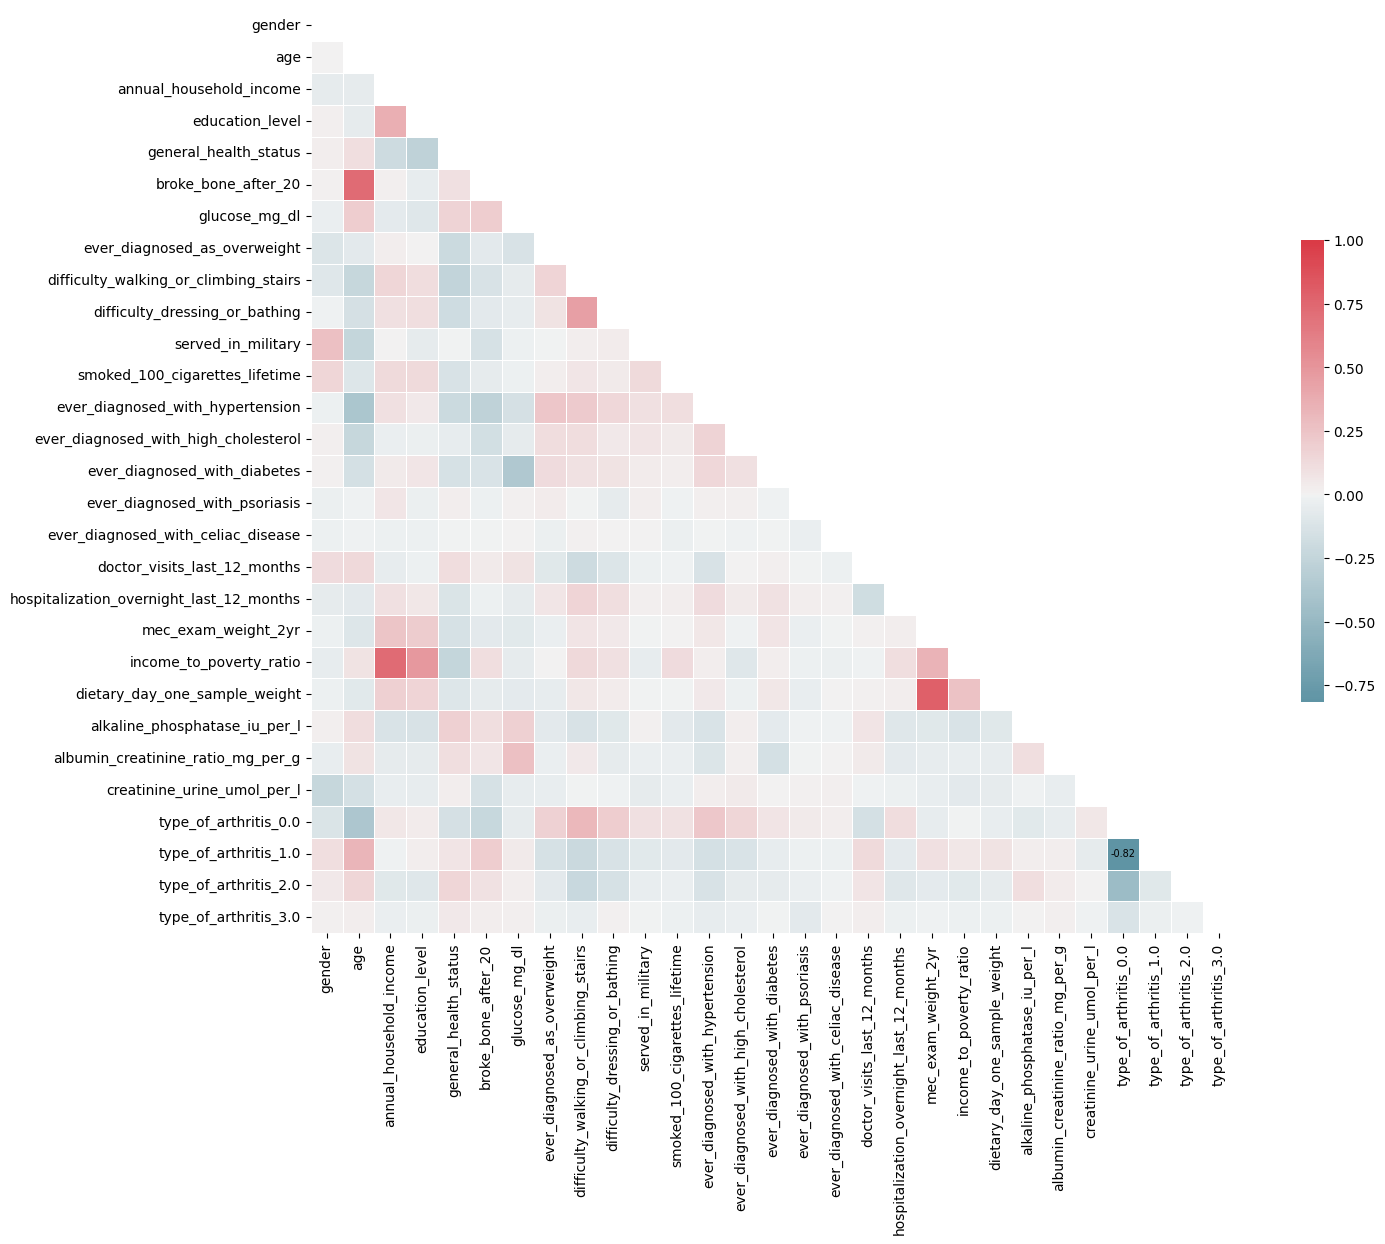

In [46]:
# Calculate corr
corr = df.corr()
# Mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
plt.figure(figsize=(17, 12))

# Create an annotation matrix with conditions for values above 0.8 or below -0.8
annot = corr.applymap(lambda x: f"{x:.2f}" if abs(x) >= 0.8 else "")

# Draw the heatmap with the mask, annotations, and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=annot, fmt="", annot_kws={"size": 7, "color": "black"})

plt.show()

The heatmap shows correlations between variables, with a few strong positive and negative relationships (e.g., high correlation between income_to_poverty_ratio and annual_household_income).

Zooming in, the target categories can be examined in more detail.

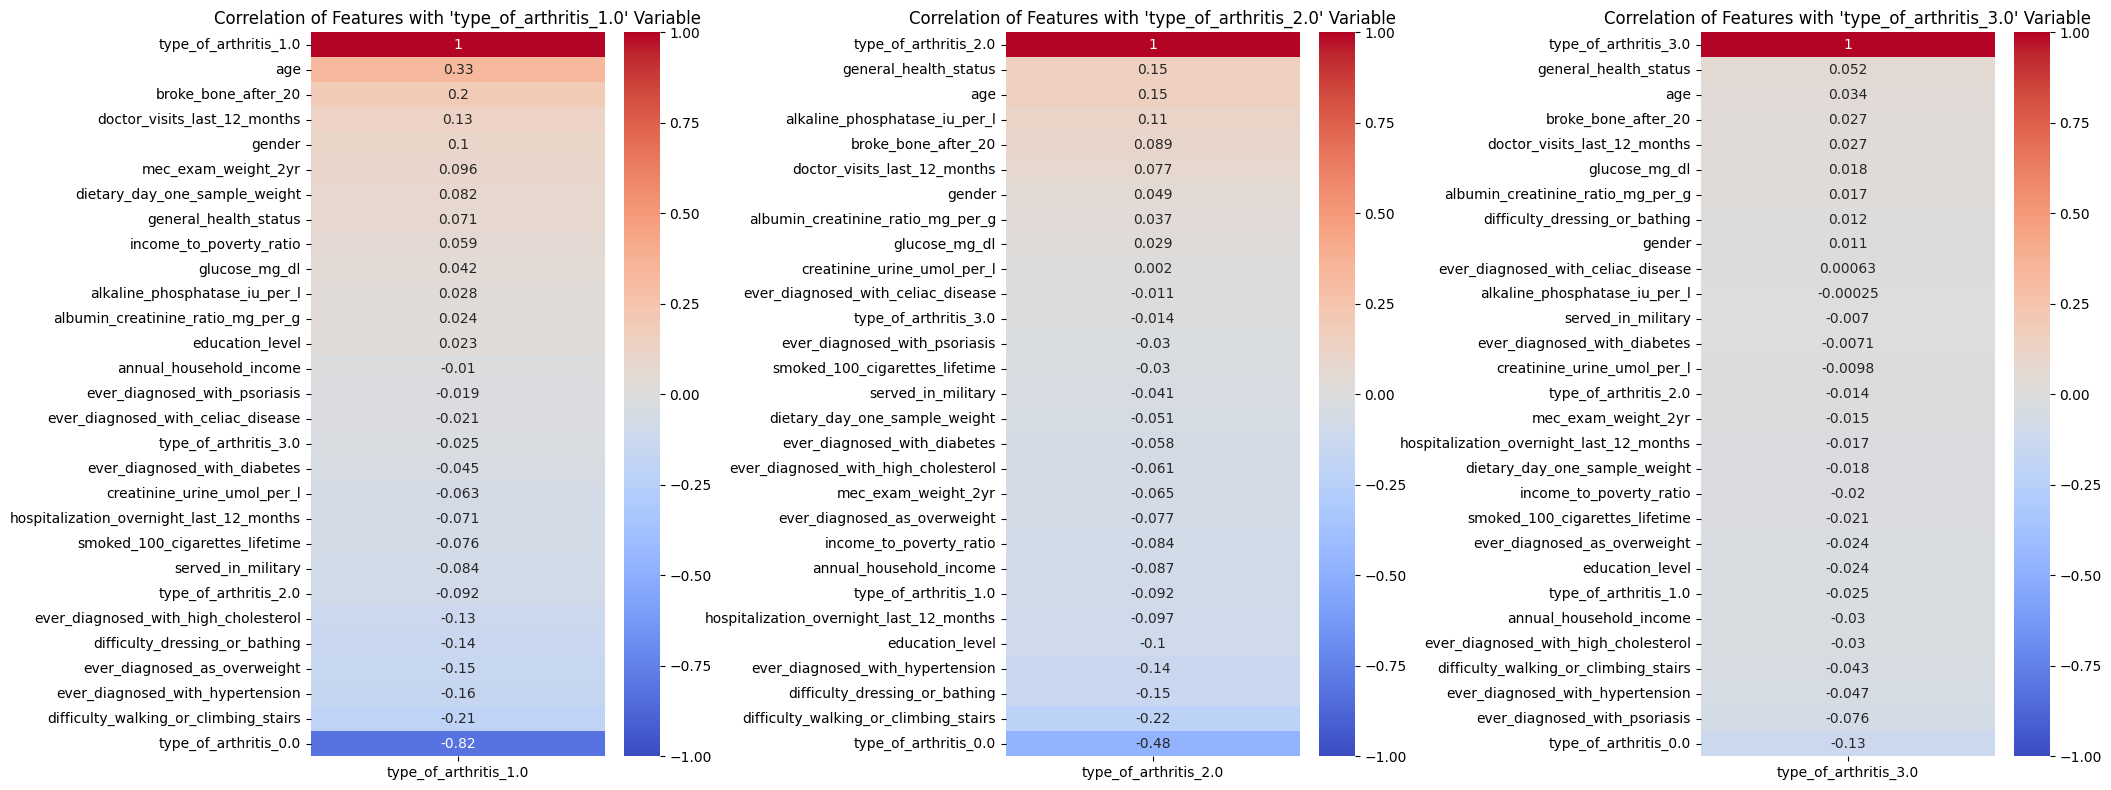

In [47]:
# Convert non-continuous columns to category dtype
df[categorical_columns] = df[categorical_columns].astype('category')

# Plot correlation heatmaps for each type of arthritis in the same figure
fig, axes = plt.subplots(1, 3, figsize=(21, 8))

for i, arthritis_type in enumerate(['type_of_arthritis_1.0', 'type_of_arthritis_2.0', 'type_of_arthritis_3.0']):
    sns.heatmap(corr[[arthritis_type]].sort_values(by=arthritis_type, ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[i])
    axes[i].set_title(f"Correlation of Features with '{arthritis_type}' Variable")

plt.tight_layout()
plt.show()

Next, scaling is applied to the data. This includes log scaling for the numerical features that are skewed and Min-Max scaling for the others.

In [48]:
log_features = ["mec_exam_weight_2yr", "dietary_day_one_sample_weight", "alkaline_phosphatase_iu_per_l", "albumin_creatinine_ratio_mg_per_g", "creatinine_urine_umol_per_l", "glucose_mg_dl"]
df[log_features] = df[log_features].apply(lambda x: np.log1p(x))
scaler = MinMaxScaler()
numerical_features_no_log = [col for col in continuous_columns if col not in log_features]
df[continuous_columns] = scaler.fit_transform(df[continuous_columns])

Next we create categorical dummy variables for our categories.

In [49]:
# Create dummy variables for other categorical columns with drop_first=True
other_categorical_columns = [col for col in categorical_columns if col != 'type_of_arthritis']
df_dummies = pd.get_dummies(df[other_categorical_columns], prefix_sep='_', drop_first=True)

# Drop original categorical columns from the DataFrame
df = df.drop(columns=categorical_columns)

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, df_dummies], axis=1)

In [50]:
targets = [col for col in df.columns if 'type_of_arthritis' in col]

### Clustering and association rules mining

In this section, two clustering algorithms are applied, followed by the application of association rule mining on the best performing clustering algorithm to enhance the model.

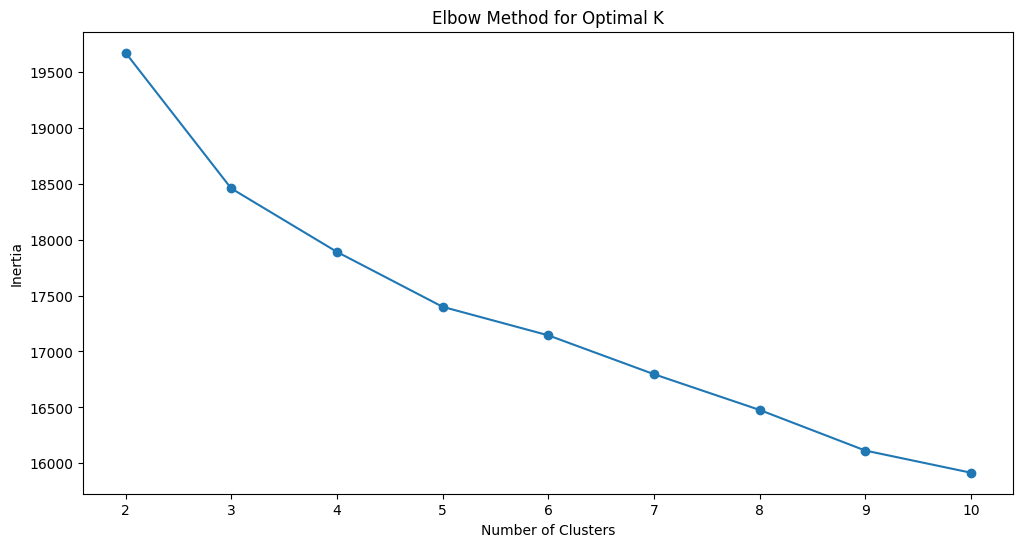

In [51]:
def compute_inertia_values(dataframe, cluster_range):
    inertias = []
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(dataframe)
        inertias.append(kmeans.inertia_)
    return inertias

def plot_elbow_method(cluster_range, inertias):
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_range, inertias, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal K')
    plt.show()


df_cluster = df.copy()
df_cluster = df_cluster.drop(columns=['type_of_arthritis_0.0','type_of_arthritis_1.0', 'type_of_arthritis_2.0', 'type_of_arthritis_3.0'])
cluster_range = range(2, 11)
km_inertia = compute_inertia_values(df_cluster, cluster_range)   
plot_elbow_method(cluster_range, km_inertia)

From the plot above, using the elbow method, the ideal `k = 5` is selected for kmeans clustering.

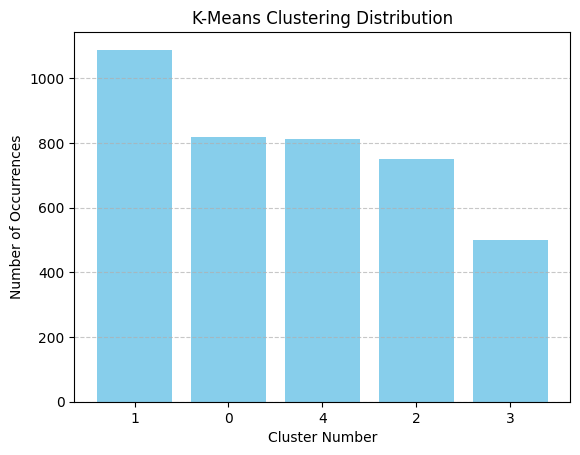

In [52]:
def kmeans_clustering(dataframe, n):
    kmeans_arr = []
    silhouette_arr = []
    for n in list(range(2, n+1)):
        kmeans = KMeans(n_clusters=n, random_state = RANDOM_STATE)
        km_clusters = kmeans.fit_predict(dataframe)
        kmeans_arr.append(km_clusters)
        silhouette_arr.append(silhouette_score(dataframe, km_clusters))
    
    # Adding the k-means cluster labels to the dataframe
    dataframe['kmeans_cluster'] = kmeans_arr[-1]

    return dataframe, kmeans_arr, silhouette_arr

def plot_cluster_distribution(dataframe, column1, title1, xlab1):
    
    cluster_counts = dataframe[column1].value_counts()

    plt.bar(cluster_counts.index.astype(str), cluster_counts.values, color='skyblue')
    plt.title(title1)
    plt.xlabel(xlab1)
    plt.ylabel('Number of Occurrences')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

km_df, km_results, sil_scores = kmeans_clustering(df_cluster, 5)
plot_cluster_distribution(km_df, 'kmeans_cluster', 'K-Means Clustering Distribution', 'Cluster Number')

From the plots above, the distribution per each cluster is visible.

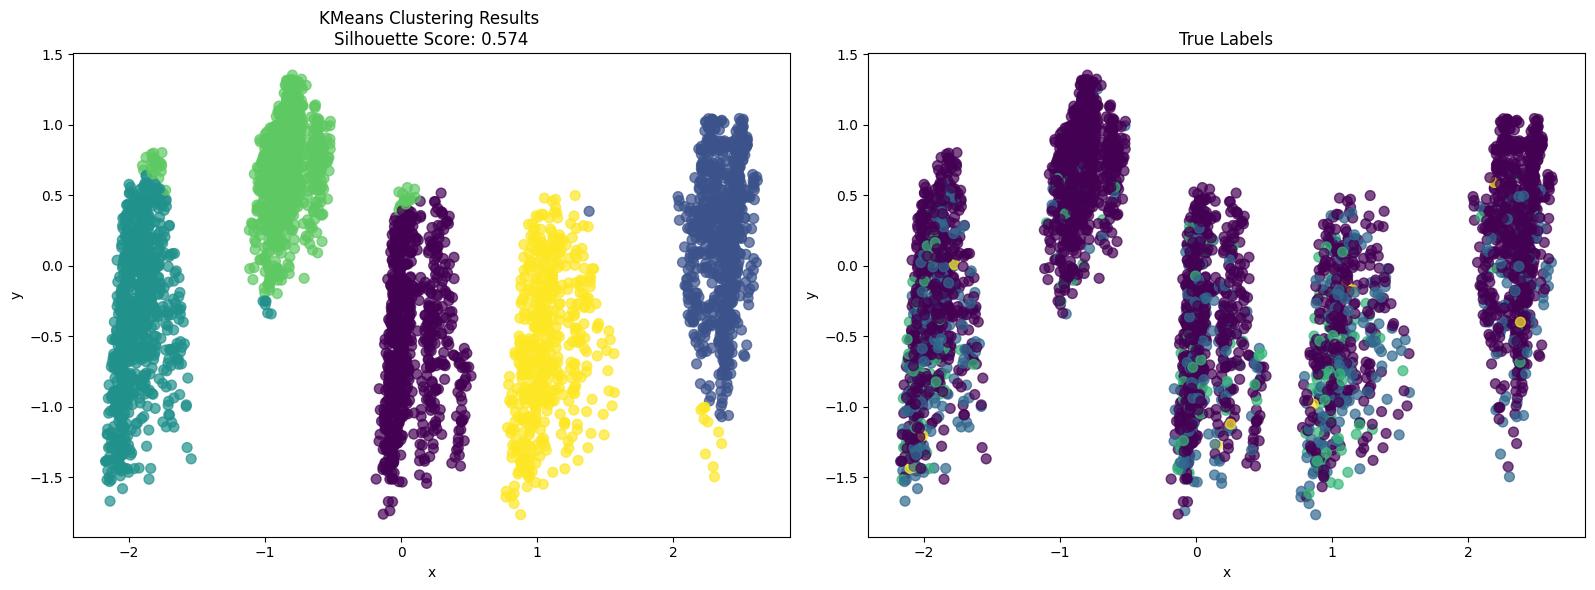

In [53]:
# Performing PCA for cluster visualization purposes
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_cluster)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def plot_kmeans_with_true_labels(dataframe, true_labels, optimal_k):
    fig = plt.figure(figsize=(24, 6))

    # Left plot: 2D Clustering Results
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)  # Replace RANDOM_STATE with 42 or any fixed number
    kmeans.fit(dataframe)
    kmeans_results = kmeans.predict(dataframe)
    silhouette_score_value = silhouette_score(dataframe, kmeans_results)

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.scatter(dataframe[:, 0], dataframe[:, 1], c=kmeans_results, cmap='viridis', s=50, alpha=0.7)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title(f'KMeans Clustering Results \nSilhouette Score: {silhouette_score_value:.3f}')

    # Right plot: 3D True Labels Visualization
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.scatter(dataframe[:, 0], dataframe[:, 1], c=true_labels, cmap='viridis', s=50, alpha=0.7)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('True Labels')

    plt.tight_layout()
    plt.show()

# Assuming df_pca is the PCA-transformed dataframe and type_of_arthritis contains the true labels
plot_kmeans_with_true_labels(df_pca, true_labels, 5)


In the plots above, the clusters identified by the algorithm are visible. Comparing them to the true labels shows that they do not represent the cluster classes well.

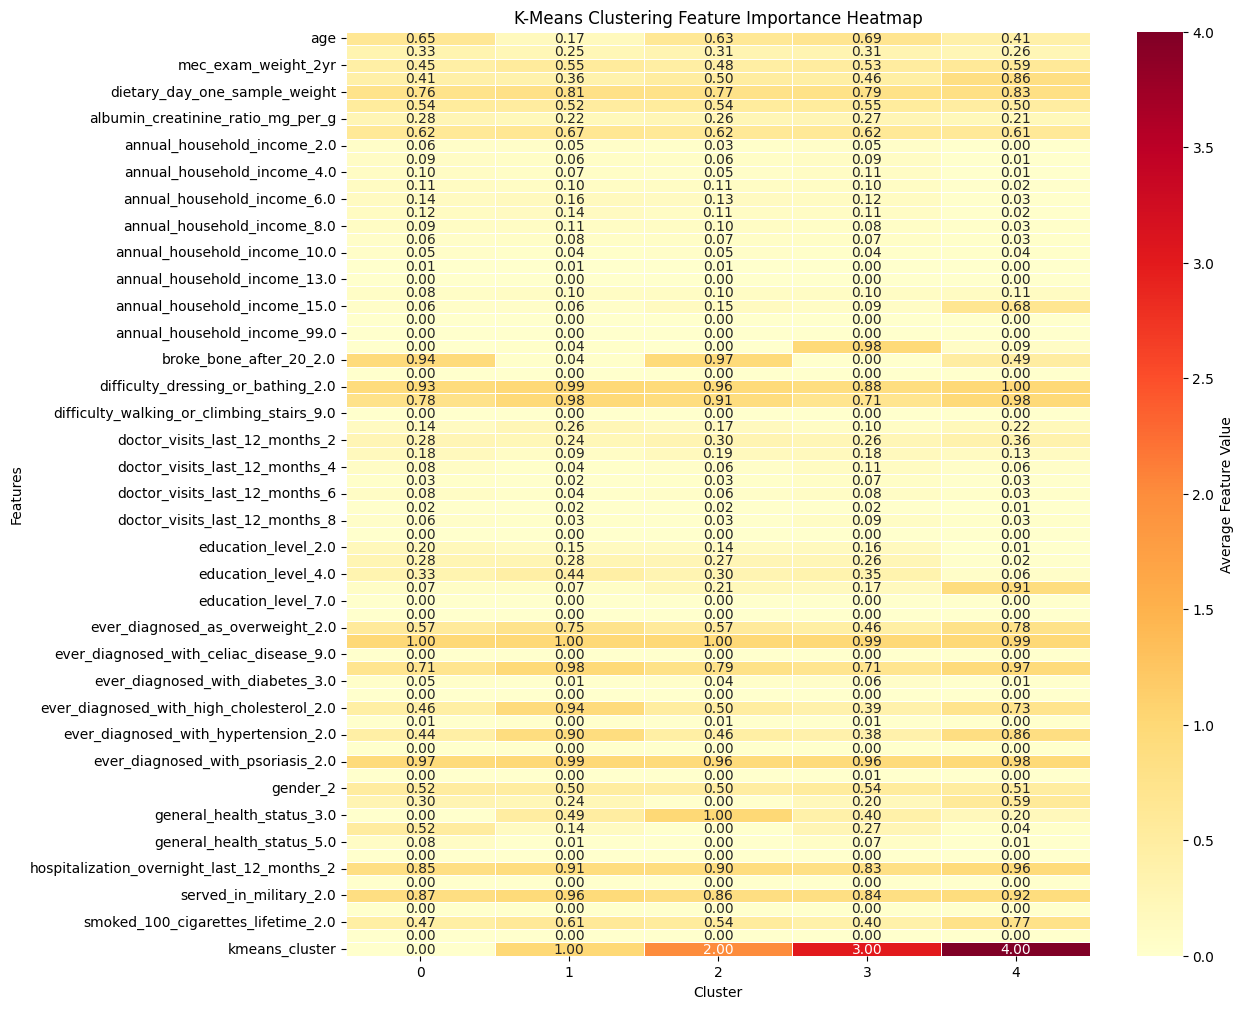

In [56]:
# Plotting a feature importance plot for the K-Means clustering
def plot_feature_importance(dataframe, labels, title):
    
    cluster_features = dataframe
    cluster_features['Cluster'] = labels
    cluster_means = cluster_features.groupby('Cluster').mean()

    plt.figure(figsize=(12, 12))
    sns.heatmap(cluster_means.T, cmap='YlOrRd', annot=True, fmt='.2f', 
                cbar_kws={'label': 'Average Feature Value'}, linewidths=0.5)
    plt.title(title)
    plt.xlabel('Cluster')
    plt.ylabel('Features')
    plt.xticks(rotation=0)
    plt.show()

plot_feature_importance(km_df, km_df['kmeans_cluster'], 'K-Means Clustering Feature Importance Heatmap')

Given this fact, hierarchical clustering can be applied to potentially get better results.

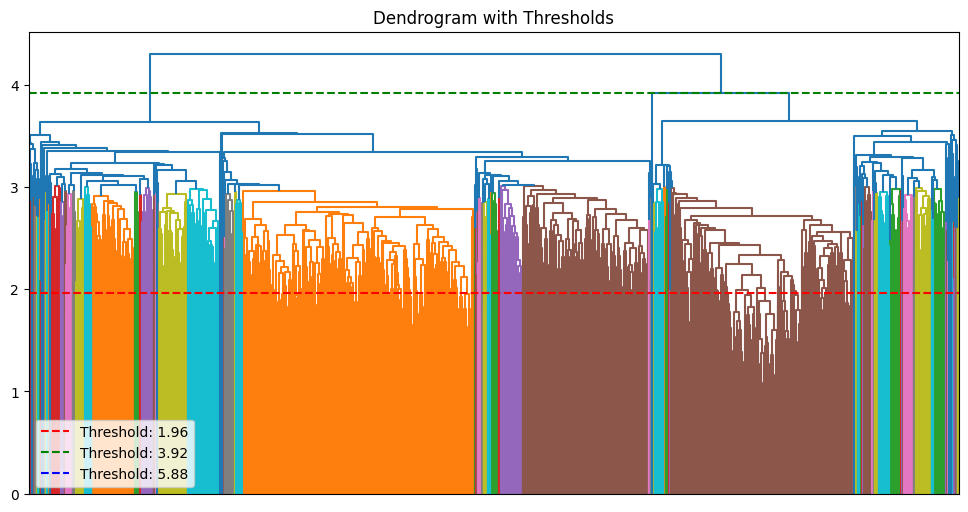

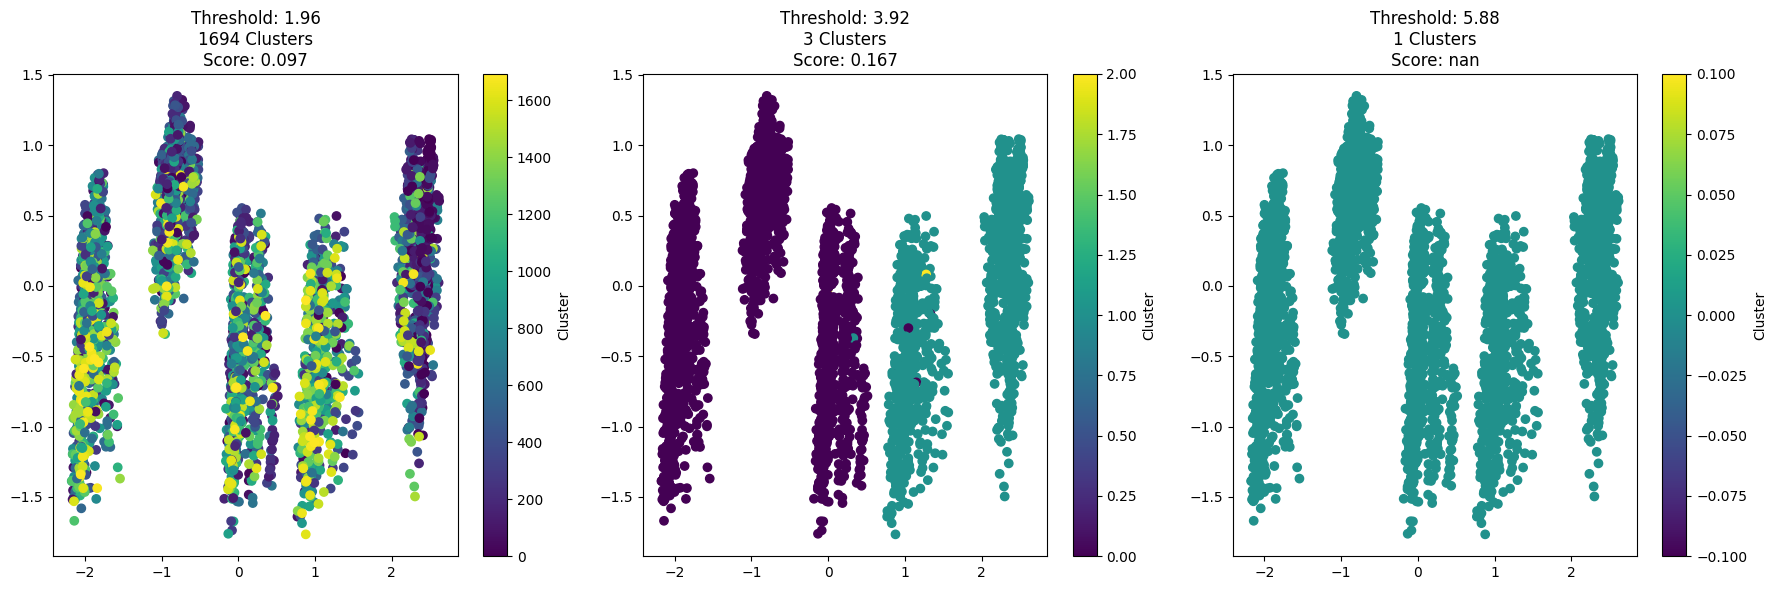

In [ ]:
def find_largest_gap(Z):
    return Z[:, 2][np.argmax(np.diff(Z[:, 2]))]

def hierarchical_clustering(data, method='average'):
    Z = linkage(data, method=method)
    threshold = find_largest_gap(Z)
    clusters = cut_tree(Z, height=threshold).flatten()
    return Z, clusters, threshold

def plot_dendrogram(Z, thresholds):
    plt.figure(figsize=(12, 6))
    dendrogram(Z, leaf_rotation=90)
    for threshold, color in zip(thresholds, ['r', 'g', 'b']):
        plt.axhline(y=threshold, color=color, linestyle='--', label=f'Threshold: {threshold:.2f}')
    plt.title('Dendrogram with Thresholds')
    plt.gca().set_xticks([])  # Remove x-axis values
    plt.legend()
    plt.show()

def visualize_threshold_effects(data, Z, thresholds, scores):
    plt.figure(figsize=(18, 6))
    for i, (threshold, score) in enumerate(zip(thresholds, scores)):
        clusters = cut_tree(Z, height=threshold).flatten()
        n_clusters = len(np.unique(clusters))
        plt.subplot(1, len(thresholds), i + 1)
        scatter = plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis')
        plt.title(f'Threshold: {threshold:.2f}\n{n_clusters} Clusters\nScore: {score:.3f}')
        plt.colorbar(scatter, label='Cluster')
    plt.tight_layout()
    plt.show()

def main_clustering_analysis(data, method='average'):
    Z, clusters, optimal_threshold = hierarchical_clustering(data, method)
    thresholds = [optimal_threshold * 0.5, optimal_threshold, optimal_threshold * 1.5]
    scores = []
    for threshold in thresholds:
        clusters = cut_tree(Z, height=threshold).flatten()
        n_clusters = len(np.unique(clusters))
        if n_clusters > 1:
            scores.append(silhouette_score(data, clusters))
        else:
            scores.append(np.nan)
    plot_dendrogram(Z, thresholds)
    pca = PCA(n_components=2).fit_transform(data)
    visualize_threshold_effects(pca, Z, thresholds, scores)
    return Z, thresholds

linkage_method = 'average'
Z, thresholds = main_clustering_analysis(df_cluster, linkage_method)


### Association Rules

With association rules, frequent itemsets are found in the data. A frequent itemset, is a set of variables that has a high likelihood of being found together. An itemset is at least a two variables, but it can be much more. The likelihood of an itemset being found, is determined through the support support thresholds. There are two types of requirements or steps in assocation rules:

1. num_itemsets: The minimum frequency required for an itemset to be considered significant. Rare itemsets with very few instances (e.g., one purchase) might show 100% purchase likelihood but have no practical application due to their low occurrence.

2. Confidence threshold: The minimum confidence level required for an itemset to predict a purchase. For example, if buying bread (A) and butter (B) leads to buying jam (C) in 75% of cases, the confidence threshold is 0.75. Association rules are identified only if they meet or exceed this confidence level in the data.

In [ ]:
df = pd.concat([df, pd.get_dummies(km_df['kmeans_cluster'], prefix='cluster')], axis=1)

In [ ]:
def transform_df_into_median_categories(df):
    df_local = df

    # For each column, calculate quartiles and create new binary columns
    for col in continuous_columns:
        if col in df_local.columns:
            # Calculate median
            median = df_local[col].median()

            # Create new binary column for values above median
            df_local[f'{col}_above_median'] = (df_local[col] > median).astype(int)

            # Drop original numerical column
            df_local.drop(columns=[col], inplace=True)
    return df_local

df_transformed = transform_df_into_median_categories(df.copy())
df_transformed

type_of_arthritis_0.0  type_of_arthritis_1.0  type_of_arthritis_2.0  \
0                         1                      0                      0   
1                         1                      0                      0   
2                         0                      0                      1   
3                         0                      0                      1   
4                         0                      0                      1   
...                     ...                    ...                    ...   
3966                      1                      0                      0   
3967                      1                      0                      0   
3968                      1                      0                      0   
3969                      1                      0                      0   
3970                      0                      1                      0   

      type_of_arthritis_3.0  annual_household_income_2.0  \
0                         0                            0   
1                         0                            0   
2                         0                            0   
3                         0                            0   
4                         0                            0   
...                     ...                          ...   
3966                      0                            0   
3967                      0                            0   
3968                      0                            0   
3969                      0                            0   
3970                      0                            0   

      annual_household_income_3.0  annual_household_income_4.0  \
0                               0                            0   
1                               0                            0   
2                               0                            0   
3                               0                            0   
4                               0                            1   
...                           ...                          ...   
3966                            1                            0   
3967                            0                            0   
3968                            0                            0   
3969                            0                            0   
3970                            0                            0   

      annual_household_income_5.0  annual_household_income_6.0  \
0                               0                            0   
1                               0                            0   
2                               0                            0   
3                               0                            0   
4                               0                            0   
...                           ...                          ...   
3966                            0                            0   
3967                            0                            0   
3968                            0                            0   
3969                            0                            0   
3970                            0                            0   

      annual_household_income_7.0  annual_household_income_8.0  \
0                               1                            0   
1                               0                            0   
2                               0                            0   
3                               0                            0   
4                               0                            0   
...                           ...                          ...   
3966                            0                            0   
3967                            0                            1   
3968                            0                            0   
3969                            0                            0   
3970                            0               

The threshold for itemsets is set to occur in at least 5% of the cases for an itemset to be considered valid.

In [ ]:
def get_itemsets_from_median_df(df_median_itemset, min_support=0.05):
    dataset = df_median_itemset
    item_sets_found = fpgrowth(dataset, min_support=min_support, use_colnames=True, max_len=4, verbose=False)   
    return item_sets_found

item_sets = get_itemsets_from_median_df(df_transformed, min_support=0.05)

Next, the rules have to be extracted from the item sets. For this only rules with lift of atleast 1 are selected.

In [ ]:
def get_rules_from_itemsets(item_sets_found, metric="lift", min_threshold=1):
    # # Generate association rules with a minimum confidence level
    rules_found = association_rules(item_sets_found, metric=metric,
                                    min_threshold=min_threshold, num_itemsets=len(item_sets_found))
    return rules_found

rules = get_rules_from_itemsets(item_sets)
rules.head(5)

antecedents  \
0  (ever_diagnosed_with_celiac_disease_2.0)   
1       (ever_diagnosed_with_psoriasis_2.0)   
2  (ever_diagnosed_with_celiac_disease_2.0)   
3      (difficulty_dressing_or_bathing_2.0)   
4      (difficulty_dressing_or_bathing_2.0)   

                                consequents  antecedent support  \
0       (ever_diagnosed_with_psoriasis_2.0)            0.994208   
1  (ever_diagnosed_with_celiac_disease_2.0)            0.973810   
2      (difficulty_dressing_or_bathing_2.0)            0.994208   
3  (ever_diagnosed_with_celiac_disease_2.0)            0.960715   
4       (ever_diagnosed_with_psoriasis_2.0)            0.960715   

   consequent support   support  confidence      lift  representativity  \
0            0.973810  0.968270    0.973911  1.000103               1.0   
1            0.994208  0.968270    0.994311  1.000103               1.0   
2            0.960715  0.955175    0.960740  1.000025               1.0   
3            0.994208  0.955175    0.994233  1.000025               1.0   
4            0.973810  0.937799    0.976147  1.002400               1.0   

   leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
0  0.000100    1.003861       0.017855  0.968514   0.003846    0.984111  
1  0.000100    1.018074       0.003949  0.968514   0.017753    0.984111  
2  0.000024    1.000622       0.004390  0.955416   0.000622    0.977486  
3  0.000024    1.004384       0.000647  0.955416   0.004365    0.977486  
4  0.002245    1.097960       0.060934  0.940879   0.089220    0.969584

Then, the code below only filters our rules such that they include the target variables:

In [ ]:
def filter_association_rules_response(df_rules):
    # Filter rows where consequents contain a target and consist of only one item
    matching_rows = [
        item for _, item in df_rules.iterrows()
        if len(item["consequents"]) == 1 and any(target in list(item["consequents"])[0] for target in targets)
    ]

    # Create a DataFrame if matching rows exist, and sort by confidence
    if len(matching_rows) > 0:
        return pd.DataFrame(matching_rows).sort_values(by="confidence", ascending=False)

    # Return an empty DataFrame if no rows match
    return pd.DataFrame()

rules_response_var_df = filter_association_rules_response(rules)
rules_response_var_df.head(3)

antecedents  \
161252     (cluster_4, general_health_status_3.0, smoked_100_cigarettes_lifetime_2.0)   
160466       (ever_diagnosed_as_overweight_2.0, cluster_4, general_health_status_3.0)   
168234  (ever_diagnosed_as_overweight_2.0, cluster_4, doctor_visits_last_12_months_2)   

                    consequents  antecedent support  consequent support  \
161252  (type_of_arthritis_0.0)            0.063964            0.808109   
160466  (type_of_arthritis_0.0)            0.083354            0.808109   
168234  (type_of_arthritis_0.0)            0.056409            0.808109   

         support  confidence      lift  representativity  leverage  \
161252  0.062956    0.984252  1.217970               1.0  0.011267   
160466  0.081592    0.978852  1.211287               1.0  0.014232   
168234  0.055150    0.977679  1.209835               1.0  0.009565   

        conviction  zhangs_metric   jaccard  certainty  kulczynski  
161252   12.185092       0.191191  0.077809   0.917933    0.531079  
160466    9.073713       0.190294  0.100746   0.889792    0.539909  
168234    8.596726       0.183810  0.068139   0.883677    0.522962

The following association rules were identified, focusing on support, confidence, and lift:

**Rule 1:**
{Cluster_4, General Health Status_3.0, Smoked_100_Cigarettes_Lifetime_2.0} → {Type of Arthritis_0.0}  
Support: 6.3%, Confidence: 98.4%, Lift: 1.22.  
Interpretation: Individuals with good general health, in Cluster 4, and who have not smoked 100 cigarettes in their lifetime are strongly associated with having no arthritis.

**Rule 2:**
{Ever Diagnosed as Overweight_2.0, Cluster_4, General Health Status_3.0} → {Type of Arthritis_0.0}  
Support: 8.2%, Confidence: 97.9%, Lift: 1.21.  
Interpretation: Not overweight individuals in Cluster 4 with good general health are highly likely to report no arthritis.

**Rule 3:**
{Ever Diagnosed as Overweight_2.0, Cluster_4, Doctor Visits Last 12 Months_2} → {Type of Arthritis_0.0}  
Support: 5.5%, Confidence: 97.8%, Lift: 1.21.  
Interpretation: Not overweight individuals in Cluster 4 with moderate doctor visits in the past year are closely associated with having no arthritis.

Finally,  the confidence column can be added to the dataset.

In [ ]:
def add_confidence_column(df_input, rules_df):
    df_input["confidence"] = 0
    rules_df = rules_df.sort_values(by="confidence", ascending=True)
    for _, rule in rules_df.iterrows():
        frozen_set = list(rule["antecedents"])
        filter_condition = df_input[frozen_set].all(axis=1)
        df_input.loc[filter_condition, 'confidence'] = rule['confidence']
    return df_input.fillna(0)

df_assoc_featured = add_confidence_column(df_transformed, rules_response_var_df)
df_assoc_featured.head(3)

type_of_arthritis_0.0  type_of_arthritis_1.0  type_of_arthritis_2.0  \
0                      1                      0                      0   
1                      1                      0                      0   
2                      0                      0                      1   

   type_of_arthritis_3.0  annual_household_income_2.0  \
0                      0                            0   
1                      0                            0   
2                      0                            0   

   annual_household_income_3.0  annual_household_income_4.0  \
0                            0                            0   
1                            0                            0   
2                            0                            0   

   annual_household_income_5.0  annual_household_income_6.0  \
0                            0                            0   
1                            0                            0   
2                            0                            0   

   annual_household_income_7.0  annual_household_income_8.0  \
0                            1                            0   
1                            0                            0   
2                            0                            0   

   annual_household_income_9.0  annual_household_income_10.0  \
0                            0                             0   
1                            0                             1   
2                            1                             0   

   annual_household_income_12.0  annual_household_income_13.0  \
0                             0                             0   
1                             0                             0   
2                             0                             0   

   annual_household_income_14.0  annual_household_income_15.0  \
0                             0                             0   
1                             0                             0   
2                             0                             0   

   annual_household_income_77.0  annual_household_income_99.0  \
0                             0                             0   
1                             0                             0   
2                             0                             0   

   broke_bone_after_20_1.0  broke_bone_after_20_2.0  broke_bone_after_20_9.0  \
0                        0                        1                        0   
1                        0                        1                        0   
2                        0                        1                        0   

   difficulty_dressing_or_bathing_2.0  \
0                                   1   
1                                   1   
2                                   1   

   difficulty_walking_or_climbing_stairs_2.0  \
0                                          1   
1                                          1   
2                                          0   

   difficulty_walking_or_climbing_stairs_9.0  doctor_visits_last_12_months_1  \
0                                          0                               0   
1                                          0                               0   
2                                          0                               0   

   doctor_visits_last_12_months_2  doctor_visits_last_12_months_3  \
0                               0                               0   
1                               1                               0   
2                               0                               1   

   doctor_visits_last_12_months_4  doctor_visits_last_12_months_5  \
0                               0                               1   
1                               0                               0   
2                               0                               0   

   doctor_visits_last_12_months_6  doctor_visits_last_12_months_7  \
0                               0                      

# Modelling

**Data Preparation**: Next, the the data ahs to be prepared for modelling by encoding targets (for XGBoost) and splitting into training and testing sets.

In [ ]:
X = df_assoc_featured.drop(columns=targets)
y = df_assoc_featured[targets].idxmax(axis=1)

# Encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

**Model Pipeline Setup**: Defines parameter grids for hyperparameter tuning of Logistic Regression, Random Forest, XGBoost, and ANN classifiers, specifying a range of values for key parameters such as regularization, tree depth, learning rate, and neural network configurations.

In [ ]:
# Define parameter grids for hyperparameter tuning

# Logistic Regression
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [1000]
}

# Support Vector Machine
param_grid_svm = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01, 0.001],
    'classifier__kernel': ['linear', 'rbf']
}

# XGBoost
param_grid_xgb = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]
}

# ANN
param_grid_ann = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__max_iter': [300]
}

Next, the pipeline are outlined for Logistic Regression, Random Forest, XGBoost, and ANN models, incorporating random oversampling for class balancing and associating each pipeline with its respective hyperparameter grid for tuning.

In [ ]:
# NOTE: In the pipelines below, we dont include preprocessor step, as we already preprocess the data beforehand.
models = {
    'Logistic Regression': (
        ImbPipeline([
            ('ros', RandomOverSampler(random_state=RANDOM_STATE)),
            ('classifier', LogisticRegression(multi_class='ovr', random_state=RANDOM_STATE))
        ]),
        param_grid_lr
    ),
    'SVM': (
        ImbPipeline([
            ('ros', RandomOverSampler(random_state=RANDOM_STATE)),
            ('classifier', SVC(random_state=RANDOM_STATE))
        ]),
        param_grid_svm
    ),
    'XGBoost': (
        ImbPipeline([
            ('ros', RandomOverSampler(random_state=RANDOM_STATE)),
            ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE))
        ]),
        param_grid_xgb
    ),
    'ANN': (
        ImbPipeline([
            ('ros', RandomOverSampler(random_state=RANDOM_STATE)),
            ('classifier', MLPClassifier(random_state=RANDOM_STATE))
        ]),
        param_grid_ann
    )
}

**Training and Evaluation with Hyperparameter Tuning**: The code below trains, tunes, and evaluates each model using GridSearchCV, storing the best model configurations and displaying performance metrics such as accuracy, classification reports, and confusion matrices for Logistic Regression, Random Forest, XGBoost, and ANN pipelines.


==================== Logistic Regression ====================
Hyperparameter tuning for Logistic Regression...
Training Logistic Regression...
Best hyperparameters for Logistic Regression: {'classifier__C': 0.01, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Accuracy: 0.6818
Classification Report:
                       precision    recall  f1-score   support

type_of_arthritis_0.0       0.96      0.72      0.82       656
type_of_arthritis_1.0       0.34      0.53      0.41        97
type_of_arthritis_2.0       0.22      0.42      0.29        38
type_of_arthritis_3.0       0.01      0.25      0.03         4

             accuracy                           0.68       795
            macro avg       0.38      0.48      0.39       795
         weighted avg       0.84      0.68      0.74       795



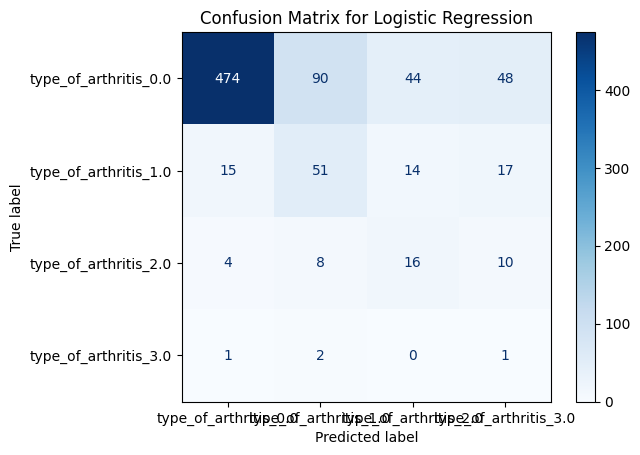


==================== SVM ====================
Hyperparameter tuning for SVM...
Training SVM...
Best hyperparameters for SVM: {'classifier__C': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Accuracy: 0.7572
Classification Report:
                       precision    recall  f1-score   support

type_of_arthritis_0.0       0.91      0.84      0.87       656
type_of_arthritis_1.0       0.32      0.51      0.39        97
type_of_arthritis_2.0       0.13      0.13      0.13        38
type_of_arthritis_3.0       0.00      0.00      0.00         4

             accuracy                           0.76       795
            macro avg       0.34      0.37      0.35       795
         weighted avg       0.80      0.76      0.77       795



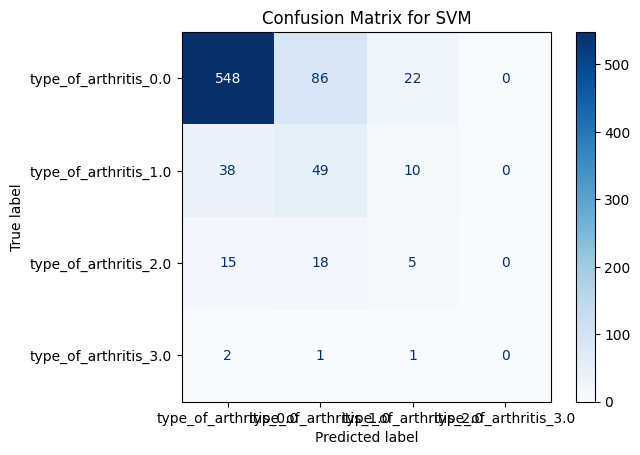


==================== XGBoost ====================
Hyperparameter tuning for XGBoost...
Training XGBoost...
Best hyperparameters for XGBoost: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Accuracy: 0.7836
Classification Report:
                       precision    recall  f1-score   support

type_of_arthritis_0.0       0.89      0.88      0.88       656
type_of_arthritis_1.0       0.35      0.40      0.38        97
type_of_arthritis_2.0       0.22      0.18      0.20        38
type_of_arthritis_3.0       0.00      0.00      0.00         4

             accuracy                           0.78       795
            macro avg       0.37      0.37      0.36       795
         weighted avg       0.79      0.78      0.79       795



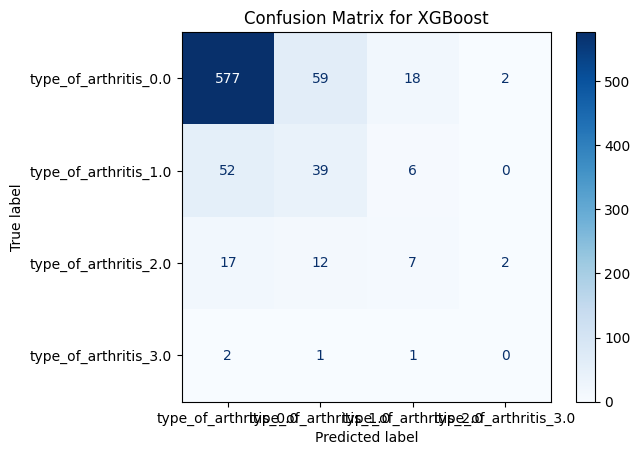


==================== ANN ====================
Hyperparameter tuning for ANN...
Training ANN...
Best hyperparameters for ANN: {'classifier__activation': 'tanh', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate': 'constant', 'classifier__max_iter': 300, 'classifier__solver': 'sgd'}
Accuracy: 0.6969
Classification Report:
                       precision    recall  f1-score   support

type_of_arthritis_0.0       0.95      0.74      0.83       656
type_of_arthritis_1.0       0.33      0.55      0.41        97
type_of_arthritis_2.0       0.15      0.45      0.22        38
type_of_arthritis_3.0       0.00      0.00      0.00         4

             accuracy                           0.70       795
            macro avg       0.36      0.43      0.37       795
         weighted avg       0.84      0.70      0.75       795



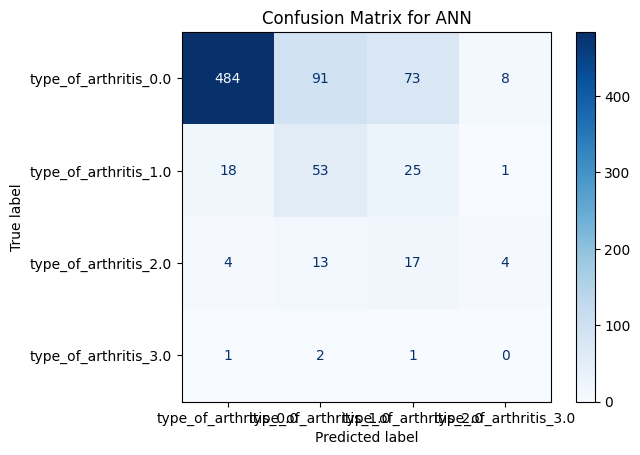

In [ ]:
best_models = {}

# Train and evaluate each model with hyperparameter tuning
for model_name, (pipeline, param_grid) in models.items():
    print(f"\n{'='*20} {model_name} {'='*20}")
    
    # Set up GridSearchCV
    print(f"Hyperparameter tuning for {model_name}...")
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=5,
        n_jobs=-1
    )
    
    # Training the model
    print(f"Training {model_name}...")
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    print(f"Best hyperparameters for {model_name}: {grid_search.best_params_}")
    
    # Store the best model
    best_models[model_name] = best_model
    
    # Predict on test data
    y_pred = best_model.predict(X_test)
    
    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

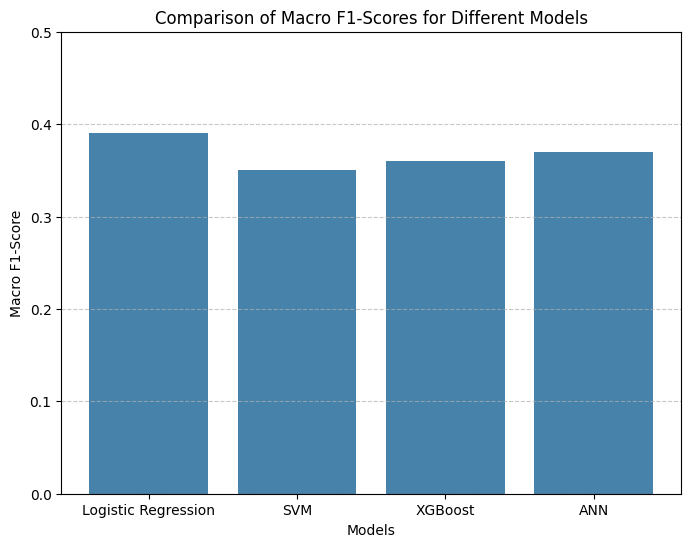

In [ ]:
# Create the bar plot with bars in the specified hex color
plt.figure(figsize=(8, 6))
plt.bar(models.keys(), [0.39, 0.35, 0.36, 0.37], color='#3274a1', alpha=0.9)
plt.title('Comparison of Macro F1-Scores for Different Models')
plt.xlabel('Models')
plt.ylabel('Macro F1-Score')
plt.ylim(0, 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

After evaluating the performance of four models—Logistic Regression, Support Vector Machine (SVM), XGBoost, and Artificial Neural Networks (ANN)—with macro-average f1-score as the key metric, the Logistic Regression model emerged as the top performer, achieving a macro-average f1-score of 0.39. This slightly outperformed ANN (0.37), XGBoost (0.36), and SVM (0.35).

The Logistic Regression model demonstrated strong classification abilities for Type 1 arthritis (f1-score: 0.41) and Type 2 arthritis (f1-score: 0.29), and provided some predictive capacity for Type 3 arthritis (f1-score: 0.03), despite the limited number of samples for this type. ANN, with a macro f1-score of 0.37, performed comparably to Logistic Regression and showed robustness in classifying more balanced classes, although it struggled with underrepresented classes.

Given that the macro-average f1-score is the primary metric of interest, Logistic Regression is the best model for this task. However, all models demonstrated limitations in handling underrepresented types, particularly Type 3 arthritis, highlighting the need for further data augmentation or advanced techniques to address class imbalance effectively.

Selecting and saving the best performing model.

In [ ]:
print("Best Model:")
best_model = best_models['Logistic Regression']
print(best_model)

# Save the model to a file
with open('best_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)
print("Model saved as 'best_model.pkl'")

Best Model:
Pipeline(steps=[('ros', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, multi_class='ovr',
                                    penalty='l1', random_state=0,
                                    solver='liblinear'))])
Model saved as 'best_model.pkl'


**Feature Importance for Tree-based Models**: The code below outputs the most important features to the tree based  models.

In [ ]:
for model_name in ['XGBoost']:
    if model_name in best_models:
        classifier = best_models[model_name].named_steps['classifier']
        print(f"\nFeature Importances for {model_name}:")
        importances = classifier.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Display top 10 features for better interpretation
        for i in indices[:10]:
            print(f"{X.columns[i]}: {importances[i]:.4f}")


Feature Importances for XGBoost:
doctor_visits_last_12_months_7: 0.0591
dietary_day_one_sample_weight_above_median: 0.0572
cluster_1: 0.0400
age_above_median: 0.0377
annual_household_income_2.0: 0.0365
difficulty_dressing_or_bathing_2.0: 0.0330
doctor_visits_last_12_months_2: 0.0317
education_level_3.0: 0.0255
annual_household_income_14.0: 0.0254
confidence: 0.0239
